# Integrating a Keras model into a Nengo network

Often we may want to define one part of our model in Nengo, and another part in TensorFlow.  For example, suppose we are building a biological reinforcement learning model, but we'd like the inputs to our model to be natural images rather than artificial vectors.  We could load a vision network from TensorFlow, insert it into our model using NengoDL, and then build the rest of our model using normal Nengo syntax.

NengoDL supports this through the [TensorNode](https://www.nengo.ai/nengo-dl/tensor_node.html) class.  This allows us to write code directly in TensorFlow, and then insert it easily into Nengo.  In this example we will demonstrate how to integrate a Keras network into a Nengo model in a series of stages. First, inserting an entire Keras model, second, inserting individual Keras layers, and third, using native Nengo objects.

In [1]:
%matplotlib inline

import threading

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import nengo
import nengo_dl

# keras uses the global random seeds, so we set those here to
# ensure the example is reproducible
seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)

**Introduction to TensorNodes**

`nengo_dl.TensorNode` works very similarly to `nengo.Node`, except instead of using the node to insert Python code into our model we will use it to insert TensorFlow code.  

The first thing we need to do is define our TensorNode output.  This is a function that accepts the current simulation time (and, optionally, a batch of vectors) as input, and produces a batch of vectors as output.  All of these variables will be represented as `tf.Tensor` objects, and the internal operations of the TensorNode will be implemented with TensorFlow operations. For example, we could use a TensorNode to output a `sin` function:

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

|#                            Simulating                              | 0:00:00

| #                           Simulating                              | 0:00:00

|  #                          Simulating                              | 0:00:00

|   #                         Simulating                              | 0:00:00

|    #                        Simulating                              | 0:00:00

|     #                       Simulating                              | 0:00:00

Simulation finished in 0:00:00                                                 

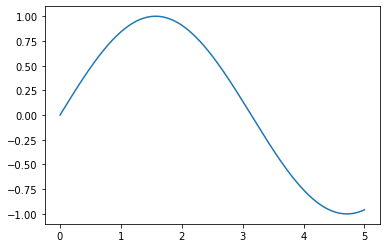

In [2]:
with nengo.Network() as net:
    def sin_func(t):
        # compute sin wave (based on simulation time)
        output = tf.sin(t)
        
        # convert output to the expected batched vector shape
        # (with batch size of 1 and vector dimensionality 1)
        output = tf.reshape(output, (1, 1))
        
        return output
    
    node = nengo_dl.TensorNode(sin_func)
    p = nengo.Probe(node)

with nengo_dl.Simulator(net) as sim:
    sim.run(5.0)
    
plt.figure()
plt.plot(sim.trange(), sim.data[p]);

However, outputting a `sin` function is something we could do more easily with a regular `nengo.Node`.  The main use case for `nengo_dl.TensorNode` is to allow us to write more complex TensorFlow code and insert it into a NengoDL model. For example, one thing we often want to do is take a deep network written in TensorFlow/Keras, and add it into a Nengo model, which is what we will focus on in this notebook.

## Inserting a whole Keras model

[Keras](https://www.tensorflow.org/guide/keras/train_and_evaluate) is a popular software package for building and training deep learning style networks.  It is a higher-level API within TensorFlow to make it easier to construct and train deep networks.  And because it is all implemented as a TensorFlow network under the hood, we can define a network using Keras and then insert it into NengoDL using a TensorNode.

This example assumes familiarity with the Keras API. Specifically it is based on the [introduction in the Tensorflow documentation](https://www.tensorflow.org/tutorials/keras/classification), so if you are not yet familiar with Keras, you may find it helpful to read those tutorials first.

In this example we'll train a neural network to classify the fashion MNIST dataset.  This dataset contains images of clothing, and the goal of the network is to identify what type of clothing it is (e.g. t-shirt, trouser, coat, etc.).

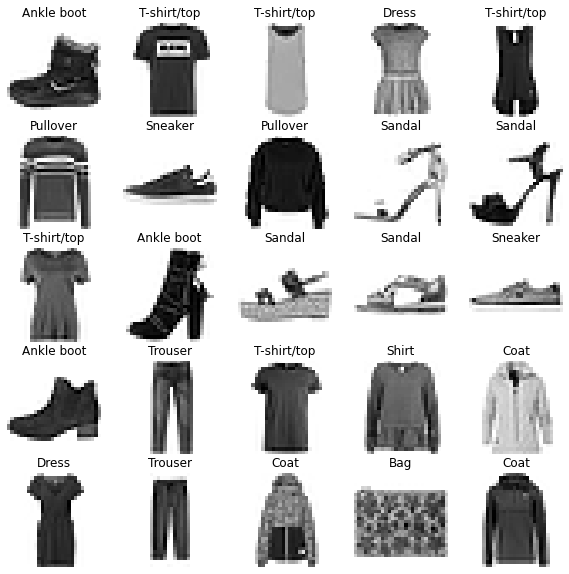

In [3]:
(train_images, train_labels), (test_images, test_labels) = (
    tf.keras.datasets.fashion_mnist.load_data())

# normalize images so values are between 0 and 1
train_images = train_images / 255.0
test_images = test_images / 255.0

# flatten images
train_images = train_images.reshape((train_images.shape[0], -1))
test_images = test_images.reshape((test_images.shape[0], -1))

class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", 
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
num_classes = len(class_names)

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(train_images[i].reshape((28, 28)), cmap=plt.cm.binary)
    plt.axis("off")
    plt.title(class_names[train_labels[i]])

Next we build and train a simple neural network, using Keras.  In this case we're building a simple two layer, densely connected network.

Note that alternatively we could define the network in Keras and then train it in NengoDL (using the `Simulator.fit` function).  But for now we'll show how to do everything in Keras.

In [4]:
inp = tf.keras.Input(train_images.shape[1:])
hidden = tf.keras.layers.Dense(units=128, activation=tf.nn.relu)(inp)
out = tf.keras.layers.Dense(units=num_classes)(hidden)

model = tf.keras.Model(inputs=inp, outputs=out)

model.compile(optimizer=tf.optimizers.Adam(), 
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])
model.fit(train_images, train_labels, epochs=5)

print("Test accuracy:", model.evaluate(test_images, test_labels, verbose=0)[1])

Epoch 1/5


   1/1875 [..............................] - ETA: 0s - loss: 2.5408 - accuracy: 0.0938

  33/1875 [..............................] - ETA: 2s - loss: 1.3831 - accuracy: 0.5511

  66/1875 [>.............................] - ETA: 2s - loss: 1.0858 - accuracy: 0.6378

  99/1875 [>.............................] - ETA: 2s - loss: 0.9796 - accuracy: 0.6717

 132/1875 [=>............................] - ETA: 2s - loss: 0.8968 - accuracy: 0.7019

 162/1875 [=>............................] - ETA: 2s - loss: 0.8528 - accuracy: 0.7141

 195/1875 [==>...........................] - ETA: 2s - loss: 0.8297 - accuracy: 0.7204

 228/1875 [==>...........................] - ETA: 2s - loss: 0.7970 - accuracy: 0.7307

 261/1875 [===>..........................] - ETA: 2s - loss: 0.7684 - accuracy: 0.7411

 294/1875 [===>..........................] - ETA: 2s - loss: 0.7458 - accuracy: 0.7472

 327/1875 [====>.........................] - ETA: 2s - loss: 0.7289 - accuracy: 0.7533

 359/1875 [====>.........................] - ETA: 2s - loss: 0.7070 - accuracy: 0.7595

 392/1875 [=====>........................] - ETA: 2s - loss: 0.6942 - accuracy: 0.7637

 425/1875 [=====>........................] - ETA: 2s - loss: 0.6811 - accuracy: 0.7684

 458/1875 [======>.......................] - ETA: 2s - loss: 0.6689 - accuracy: 0.7715

 491/1875 [======>.......................] - ETA: 2s - loss: 0.6574 - accuracy: 0.7744

 524/1875 [=======>......................] - ETA: 2s - loss: 0.6493 - accuracy: 0.7762

 557/1875 [=======>......................] - ETA: 2s - loss: 0.6388 - accuracy: 0.7793

 590/1875 [========>.....................] - ETA: 2s - loss: 0.6308 - accuracy: 0.7825

 621/1875 [========>.....................] - ETA: 1s - loss: 0.6224 - accuracy: 0.7850

 654/1875 [=========>....................] - ETA: 1s - loss: 0.6136 - accuracy: 0.7884

 687/1875 [=========>....................] - ETA: 1s - loss: 0.6073 - accuracy: 0.7908

 720/1875 [==========>...................] - ETA: 1s - loss: 0.6023 - accuracy: 0.7923

 753/1875 [===========>..................] - ETA: 1s - loss: 0.5971 - accuracy: 0.7937

 786/1875 [===========>..................] - ETA: 1s - loss: 0.5918 - accuracy: 0.7954

 817/1875 [============>.................] - ETA: 1s - loss: 0.5872 - accuracy: 0.7965

 850/1875 [============>.................] - ETA: 1s - loss: 0.5832 - accuracy: 0.7978

 882/1875 [=============>................] - ETA: 1s - loss: 0.5795 - accuracy: 0.7990

 915/1875 [=============>................] - ETA: 1s - loss: 0.5769 - accuracy: 0.7998

 945/1875 [==============>...............] - ETA: 1s - loss: 0.5722 - accuracy: 0.8012

 977/1875 [==============>...............] - ETA: 1s - loss: 0.5687 - accuracy: 0.8026

1009/1875 [===============>..............] - ETA: 1s - loss: 0.5645 - accuracy: 0.8043

1040/1875 [===============>..............] - ETA: 1s - loss: 0.5610 - accuracy: 0.8059

1073/1875 [================>.............] - ETA: 1s - loss: 0.5571 - accuracy: 0.8068

1105/1875 [================>.............] - ETA: 1s - loss: 0.5538 - accuracy: 0.8078

1138/1875 [=================>............] - ETA: 1s - loss: 0.5506 - accuracy: 0.8089

1170/1875 [=================>............] - ETA: 1s - loss: 0.5468 - accuracy: 0.8100

1201/1875 [==================>...........] - ETA: 1s - loss: 0.5448 - accuracy: 0.8109

1233/1875 [==================>...........] - ETA: 1s - loss: 0.5412 - accuracy: 0.8123

1264/1875 [===================>..........] - ETA: 0s - loss: 0.5383 - accuracy: 0.8128

1295/1875 [===================>..........] - ETA: 0s - loss: 0.5352 - accuracy: 0.8138

1327/1875 [====================>.........] - ETA: 0s - loss: 0.5308 - accuracy: 0.8153

1359/1875 [====================>.........] - ETA: 0s - loss: 0.5280 - accuracy: 0.8159

1388/1875 [=====================>........] - ETA: 0s - loss: 0.5262 - accuracy: 0.8164

1419/1875 [=====================>........] - ETA: 0s - loss: 0.5252 - accuracy: 0.8165

1449/1875 [======================>.......] - ETA: 0s - loss: 0.5227 - accuracy: 0.8172

1482/1875 [======================>.......] - ETA: 0s - loss: 0.5213 - accuracy: 0.8178

1513/1875 [=======================>......] - ETA: 0s - loss: 0.5182 - accuracy: 0.8186

1541/1875 [=======================>......] - ETA: 0s - loss: 0.5164 - accuracy: 0.8191

1573/1875 [========================>.....] - ETA: 0s - loss: 0.5145 - accuracy: 0.8195

1604/1875 [========================>.....] - ETA: 0s - loss: 0.5125 - accuracy: 0.8202

1635/1875 [=========================>....] - ETA: 0s - loss: 0.5102 - accuracy: 0.8211

1666/1875 [=========================>....] - ETA: 0s - loss: 0.5083 - accuracy: 0.8217

1698/1875 [==========================>...] - ETA: 0s - loss: 0.5073 - accuracy: 0.8221

1729/1875 [==========================>...] - ETA: 0s - loss: 0.5051 - accuracy: 0.8226

1760/1875 [===========================>..] - ETA: 0s - loss: 0.5034 - accuracy: 0.8232

1792/1875 [===========================>..] - ETA: 0s - loss: 0.5018 - accuracy: 0.8237

1825/1875 [============================>.] - ETA: 0s - loss: 0.5004 - accuracy: 0.8240

1855/1875 [============================>.] - ETA: 0s - loss: 0.4983 - accuracy: 0.8250

1875/1875 [==============================] - 3s 2ms/step - loss: 0.4979 - accuracy: 0.8251


Epoch 2/5
   1/1875 [..............................] - ETA: 0s - loss: 0.2846 - accuracy: 0.8438

  34/1875 [..............................] - ETA: 2s - loss: 0.4039 - accuracy: 0.8539

  67/1875 [>.............................] - ETA: 2s - loss: 0.3915 - accuracy: 0.8535

 100/1875 [>.............................] - ETA: 2s - loss: 0.3817 - accuracy: 0.8581

 131/1875 [=>............................] - ETA: 2s - loss: 0.3886 - accuracy: 0.8571

 164/1875 [=>............................] - ETA: 2s - loss: 0.3914 - accuracy: 0.8561

 196/1875 [==>...........................] - ETA: 2s - loss: 0.3895 - accuracy: 0.8579

 229/1875 [==>...........................] - ETA: 2s - loss: 0.3871 - accuracy: 0.8614

 261/1875 [===>..........................] - ETA: 2s - loss: 0.3892 - accuracy: 0.8603

 294/1875 [===>..........................] - ETA: 2s - loss: 0.3846 - accuracy: 0.8617

 326/1875 [====>.........................] - ETA: 2s - loss: 0.3859 - accuracy: 0.8608

 354/1875 [====>.........................] - ETA: 2s - loss: 0.3855 - accuracy: 0.8605

 385/1875 [=====>........................] - ETA: 2s - loss: 0.3850 - accuracy: 0.8610

 418/1875 [=====>........................] - ETA: 2s - loss: 0.3860 - accuracy: 0.8618

 451/1875 [======>.......................] - ETA: 2s - loss: 0.3845 - accuracy: 0.8626

 477/1875 [======>.......................] - ETA: 2s - loss: 0.3865 - accuracy: 0.8620

 506/1875 [=======>......................] - ETA: 2s - loss: 0.3869 - accuracy: 0.8607

 538/1875 [=======>......................] - ETA: 2s - loss: 0.3863 - accuracy: 0.8607

 570/1875 [========>.....................] - ETA: 2s - loss: 0.3874 - accuracy: 0.8603

 601/1875 [========>.....................] - ETA: 2s - loss: 0.3870 - accuracy: 0.8602

 631/1875 [=========>....................] - ETA: 2s - loss: 0.3863 - accuracy: 0.8599

 663/1875 [=========>....................] - ETA: 1s - loss: 0.3844 - accuracy: 0.8613

 696/1875 [==========>...................] - ETA: 1s - loss: 0.3813 - accuracy: 0.8627

 729/1875 [==========>...................] - ETA: 1s - loss: 0.3808 - accuracy: 0.8625

 757/1875 [===========>..................] - ETA: 1s - loss: 0.3797 - accuracy: 0.8625

 788/1875 [===========>..................] - ETA: 1s - loss: 0.3800 - accuracy: 0.8623

 818/1875 [============>.................] - ETA: 1s - loss: 0.3813 - accuracy: 0.8617

 848/1875 [============>.................] - ETA: 1s - loss: 0.3819 - accuracy: 0.8615

 879/1875 [=============>................] - ETA: 1s - loss: 0.3818 - accuracy: 0.8614

 910/1875 [=============>................] - ETA: 1s - loss: 0.3801 - accuracy: 0.8620

 942/1875 [==============>...............] - ETA: 1s - loss: 0.3796 - accuracy: 0.8622

 975/1875 [==============>...............] - ETA: 1s - loss: 0.3796 - accuracy: 0.8622

1007/1875 [===============>..............] - ETA: 1s - loss: 0.3783 - accuracy: 0.8626

1040/1875 [===============>..............] - ETA: 1s - loss: 0.3780 - accuracy: 0.8627

1073/1875 [================>.............] - ETA: 1s - loss: 0.3774 - accuracy: 0.8628

1104/1875 [================>.............] - ETA: 1s - loss: 0.3774 - accuracy: 0.8627

1136/1875 [=================>............] - ETA: 1s - loss: 0.3768 - accuracy: 0.8631

1168/1875 [=================>............] - ETA: 1s - loss: 0.3769 - accuracy: 0.8629

1200/1875 [==================>...........] - ETA: 1s - loss: 0.3762 - accuracy: 0.8630

1231/1875 [==================>...........] - ETA: 1s - loss: 0.3748 - accuracy: 0.8635

1263/1875 [===================>..........] - ETA: 0s - loss: 0.3748 - accuracy: 0.8635

1295/1875 [===================>..........] - ETA: 0s - loss: 0.3744 - accuracy: 0.8637

1323/1875 [====================>.........] - ETA: 0s - loss: 0.3747 - accuracy: 0.8637

1355/1875 [====================>.........] - ETA: 0s - loss: 0.3755 - accuracy: 0.8637

1386/1875 [=====================>........] - ETA: 0s - loss: 0.3750 - accuracy: 0.8641

1418/1875 [=====================>........] - ETA: 0s - loss: 0.3744 - accuracy: 0.8640

1451/1875 [======================>.......] - ETA: 0s - loss: 0.3736 - accuracy: 0.8643

1483/1875 [======================>.......] - ETA: 0s - loss: 0.3735 - accuracy: 0.8642

1515/1875 [=======================>......] - ETA: 0s - loss: 0.3738 - accuracy: 0.8643

1548/1875 [=======================>......] - ETA: 0s - loss: 0.3744 - accuracy: 0.8641

1577/1875 [========================>.....] - ETA: 0s - loss: 0.3742 - accuracy: 0.8643

1605/1875 [========================>.....] - ETA: 0s - loss: 0.3734 - accuracy: 0.8647

1638/1875 [=========================>....] - ETA: 0s - loss: 0.3732 - accuracy: 0.8648

1671/1875 [=========================>....] - ETA: 0s - loss: 0.3725 - accuracy: 0.8652

1703/1875 [==========================>...] - ETA: 0s - loss: 0.3725 - accuracy: 0.8653

1735/1875 [==========================>...] - ETA: 0s - loss: 0.3717 - accuracy: 0.8656

1767/1875 [===========================>..] - ETA: 0s - loss: 0.3712 - accuracy: 0.8659

1800/1875 [===========================>..] - ETA: 0s - loss: 0.3713 - accuracy: 0.8659

1833/1875 [============================>.] - ETA: 0s - loss: 0.3709 - accuracy: 0.8662

1866/1875 [============================>.] - ETA: 0s - loss: 0.3706 - accuracy: 0.8664

1875/1875 [==============================] - 3s 2ms/step - loss: 0.3706 - accuracy: 0.8663


Epoch 3/5
   1/1875 [..............................] - ETA: 0s - loss: 0.4551 - accuracy: 0.9375

  33/1875 [..............................] - ETA: 2s - loss: 0.3202 - accuracy: 0.8949

  65/1875 [>.............................] - ETA: 2s - loss: 0.3440 - accuracy: 0.8769

  98/1875 [>.............................] - ETA: 2s - loss: 0.3314 - accuracy: 0.8827

 131/1875 [=>............................] - ETA: 2s - loss: 0.3329 - accuracy: 0.8817

 163/1875 [=>............................] - ETA: 2s - loss: 0.3307 - accuracy: 0.8813

 196/1875 [==>...........................] - ETA: 2s - loss: 0.3356 - accuracy: 0.8777

 229/1875 [==>...........................] - ETA: 2s - loss: 0.3313 - accuracy: 0.8784

 261/1875 [===>..........................] - ETA: 2s - loss: 0.3339 - accuracy: 0.8794

 293/1875 [===>..........................] - ETA: 2s - loss: 0.3399 - accuracy: 0.8778

 322/1875 [====>.........................] - ETA: 2s - loss: 0.3436 - accuracy: 0.8759

 354/1875 [====>.........................] - ETA: 2s - loss: 0.3447 - accuracy: 0.8759

 386/1875 [=====>........................] - ETA: 2s - loss: 0.3451 - accuracy: 0.8753

 419/1875 [=====>........................] - ETA: 2s - loss: 0.3443 - accuracy: 0.8745

 452/1875 [======>.......................] - ETA: 2s - loss: 0.3418 - accuracy: 0.8751

 485/1875 [======>.......................] - ETA: 2s - loss: 0.3387 - accuracy: 0.8762

 517/1875 [=======>......................] - ETA: 2s - loss: 0.3374 - accuracy: 0.8767

 550/1875 [=======>......................] - ETA: 2s - loss: 0.3384 - accuracy: 0.8766

 582/1875 [========>.....................] - ETA: 2s - loss: 0.3394 - accuracy: 0.8761

 615/1875 [========>.....................] - ETA: 1s - loss: 0.3394 - accuracy: 0.8767

 648/1875 [=========>....................] - ETA: 1s - loss: 0.3396 - accuracy: 0.8760

 680/1875 [=========>....................] - ETA: 1s - loss: 0.3414 - accuracy: 0.8759

 706/1875 [==========>...................] - ETA: 1s - loss: 0.3433 - accuracy: 0.8751

 738/1875 [==========>...................] - ETA: 1s - loss: 0.3427 - accuracy: 0.8752

 770/1875 [===========>..................] - ETA: 1s - loss: 0.3397 - accuracy: 0.8759

 803/1875 [===========>..................] - ETA: 1s - loss: 0.3369 - accuracy: 0.8770

 836/1875 [============>.................] - ETA: 1s - loss: 0.3382 - accuracy: 0.8762

 869/1875 [============>.................] - ETA: 1s - loss: 0.3376 - accuracy: 0.8764

 901/1875 [=============>................] - ETA: 1s - loss: 0.3359 - accuracy: 0.8769

 934/1875 [=============>................] - ETA: 1s - loss: 0.3369 - accuracy: 0.8768

 966/1875 [==============>...............] - ETA: 1s - loss: 0.3355 - accuracy: 0.8776

 998/1875 [==============>...............] - ETA: 1s - loss: 0.3353 - accuracy: 0.8774

1030/1875 [===============>..............] - ETA: 1s - loss: 0.3358 - accuracy: 0.8773

1060/1875 [===============>..............] - ETA: 1s - loss: 0.3359 - accuracy: 0.8773

1093/1875 [================>.............] - ETA: 1s - loss: 0.3353 - accuracy: 0.8773

1126/1875 [=================>............] - ETA: 1s - loss: 0.3349 - accuracy: 0.8776

1158/1875 [=================>............] - ETA: 1s - loss: 0.3348 - accuracy: 0.8778

1191/1875 [==================>...........] - ETA: 1s - loss: 0.3350 - accuracy: 0.8775

1224/1875 [==================>...........] - ETA: 1s - loss: 0.3343 - accuracy: 0.8775

1256/1875 [===================>..........] - ETA: 0s - loss: 0.3346 - accuracy: 0.8775

1289/1875 [===================>..........] - ETA: 0s - loss: 0.3348 - accuracy: 0.8773

1320/1875 [====================>.........] - ETA: 0s - loss: 0.3339 - accuracy: 0.8779

1350/1875 [====================>.........] - ETA: 0s - loss: 0.3349 - accuracy: 0.8774

1381/1875 [=====================>........] - ETA: 0s - loss: 0.3352 - accuracy: 0.8773

1413/1875 [=====================>........] - ETA: 0s - loss: 0.3366 - accuracy: 0.8771

1445/1875 [======================>.......] - ETA: 0s - loss: 0.3361 - accuracy: 0.8772

1479/1875 [======================>.......] - ETA: 0s - loss: 0.3356 - accuracy: 0.8775

1512/1875 [=======================>......] - ETA: 0s - loss: 0.3354 - accuracy: 0.8777

1545/1875 [=======================>......] - ETA: 0s - loss: 0.3346 - accuracy: 0.8780

1578/1875 [========================>.....] - ETA: 0s - loss: 0.3346 - accuracy: 0.8780

1611/1875 [========================>.....] - ETA: 0s - loss: 0.3347 - accuracy: 0.8779

1641/1875 [=========================>....] - ETA: 0s - loss: 0.3345 - accuracy: 0.8781

1672/1875 [=========================>....] - ETA: 0s - loss: 0.3341 - accuracy: 0.8782

1703/1875 [==========================>...] - ETA: 0s - loss: 0.3336 - accuracy: 0.8784

1736/1875 [==========================>...] - ETA: 0s - loss: 0.3335 - accuracy: 0.8783

1768/1875 [===========================>..] - ETA: 0s - loss: 0.3335 - accuracy: 0.8783

1798/1875 [===========================>..] - ETA: 0s - loss: 0.3339 - accuracy: 0.8781

1831/1875 [============================>.] - ETA: 0s - loss: 0.3326 - accuracy: 0.8787

1864/1875 [============================>.] - ETA: 0s - loss: 0.3319 - accuracy: 0.8788

1875/1875 [==============================] - 3s 2ms/step - loss: 0.3319 - accuracy: 0.8787


Epoch 4/5
   1/1875 [..............................] - ETA: 0s - loss: 0.4428 - accuracy: 0.8750

  34/1875 [..............................] - ETA: 2s - loss: 0.3173 - accuracy: 0.8860

  67/1875 [>.............................] - ETA: 2s - loss: 0.3206 - accuracy: 0.8913

  99/1875 [>.............................] - ETA: 2s - loss: 0.3225 - accuracy: 0.8898

 132/1875 [=>............................] - ETA: 2s - loss: 0.3212 - accuracy: 0.8878

 164/1875 [=>............................] - ETA: 2s - loss: 0.3244 - accuracy: 0.8855

 196/1875 [==>...........................] - ETA: 2s - loss: 0.3157 - accuracy: 0.8865

 229/1875 [==>...........................] - ETA: 2s - loss: 0.3109 - accuracy: 0.8885

 260/1875 [===>..........................] - ETA: 2s - loss: 0.3123 - accuracy: 0.8887

 292/1875 [===>..........................] - ETA: 2s - loss: 0.3156 - accuracy: 0.8867

 325/1875 [====>.........................] - ETA: 2s - loss: 0.3136 - accuracy: 0.8866

 356/1875 [====>.........................] - ETA: 2s - loss: 0.3174 - accuracy: 0.8842

 377/1875 [=====>........................] - ETA: 2s - loss: 0.3186 - accuracy: 0.8837

 405/1875 [=====>........................] - ETA: 2s - loss: 0.3168 - accuracy: 0.8846

 438/1875 [======>.......................] - ETA: 2s - loss: 0.3135 - accuracy: 0.8853

 471/1875 [======>.......................] - ETA: 2s - loss: 0.3143 - accuracy: 0.8852

 504/1875 [=======>......................] - ETA: 2s - loss: 0.3144 - accuracy: 0.8847

 537/1875 [=======>......................] - ETA: 2s - loss: 0.3157 - accuracy: 0.8839

 570/1875 [========>.....................] - ETA: 2s - loss: 0.3126 - accuracy: 0.8849

 602/1875 [========>.....................] - ETA: 2s - loss: 0.3133 - accuracy: 0.8844

 633/1875 [=========>....................] - ETA: 1s - loss: 0.3132 - accuracy: 0.8845

 666/1875 [=========>....................] - ETA: 1s - loss: 0.3141 - accuracy: 0.8850

 698/1875 [==========>...................] - ETA: 1s - loss: 0.3128 - accuracy: 0.8855



 730/1875 [==========>...................] - ETA: 1s - loss: 0.3129 - accuracy: 0.8856

 761/1875 [===========>..................] - ETA: 1s - loss: 0.3117 - accuracy: 0.8863

 794/1875 [===========>..................] - ETA: 1s - loss: 0.3131 - accuracy: 0.8859

 827/1875 [============>.................] - ETA: 1s - loss: 0.3137 - accuracy: 0.8858

 860/1875 [============>.................] - ETA: 1s - loss: 0.3126 - accuracy: 0.8865

 893/1875 [=============>................] - ETA: 1s - loss: 0.3120 - accuracy: 0.8867

 926/1875 [=============>................] - ETA: 1s - loss: 0.3109 - accuracy: 0.8869

 958/1875 [==============>...............] - ETA: 1s - loss: 0.3114 - accuracy: 0.8866

 989/1875 [==============>...............] - ETA: 1s - loss: 0.3100 - accuracy: 0.8871

1019/1875 [===============>..............] - ETA: 1s - loss: 0.3097 - accuracy: 0.8869

1052/1875 [===============>..............] - ETA: 1s - loss: 0.3093 - accuracy: 0.8870

1085/1875 [================>.............] - ETA: 1s - loss: 0.3090 - accuracy: 0.8871

1118/1875 [================>.............] - ETA: 1s - loss: 0.3092 - accuracy: 0.8874

1151/1875 [=================>............] - ETA: 1s - loss: 0.3100 - accuracy: 0.8871

1184/1875 [=================>............] - ETA: 1s - loss: 0.3087 - accuracy: 0.8875

1216/1875 [==================>...........] - ETA: 1s - loss: 0.3085 - accuracy: 0.8874

1247/1875 [==================>...........] - ETA: 0s - loss: 0.3081 - accuracy: 0.8876

1280/1875 [===================>..........] - ETA: 0s - loss: 0.3068 - accuracy: 0.8880

1313/1875 [====================>.........] - ETA: 0s - loss: 0.3074 - accuracy: 0.8876

1345/1875 [====================>.........] - ETA: 0s - loss: 0.3074 - accuracy: 0.8876

1378/1875 [=====================>........] - ETA: 0s - loss: 0.3080 - accuracy: 0.8873

1410/1875 [=====================>........] - ETA: 0s - loss: 0.3084 - accuracy: 0.8872

1443/1875 [======================>.......] - ETA: 0s - loss: 0.3085 - accuracy: 0.8871

1475/1875 [======================>.......] - ETA: 0s - loss: 0.3087 - accuracy: 0.8870

1508/1875 [=======================>......] - ETA: 0s - loss: 0.3087 - accuracy: 0.8869

1539/1875 [=======================>......] - ETA: 0s - loss: 0.3086 - accuracy: 0.8869

1572/1875 [========================>.....] - ETA: 0s - loss: 0.3088 - accuracy: 0.8868

1605/1875 [========================>.....] - ETA: 0s - loss: 0.3088 - accuracy: 0.8869

1635/1875 [=========================>....] - ETA: 0s - loss: 0.3080 - accuracy: 0.8870

1665/1875 [=========================>....] - ETA: 0s - loss: 0.3081 - accuracy: 0.8871

1697/1875 [==========================>...] - ETA: 0s - loss: 0.3089 - accuracy: 0.8869

1730/1875 [==========================>...] - ETA: 0s - loss: 0.3093 - accuracy: 0.8868

1763/1875 [===========================>..] - ETA: 0s - loss: 0.3094 - accuracy: 0.8868

1796/1875 [===========================>..] - ETA: 0s - loss: 0.3094 - accuracy: 0.8867

1829/1875 [============================>.] - ETA: 0s - loss: 0.3092 - accuracy: 0.8867

1862/1875 [============================>.] - ETA: 0s - loss: 0.3088 - accuracy: 0.8866

1875/1875 [==============================] - 3s 2ms/step - loss: 0.3087 - accuracy: 0.8866


Epoch 5/5
   1/1875 [..............................] - ETA: 0s - loss: 0.1173 - accuracy: 0.9688

  33/1875 [..............................] - ETA: 2s - loss: 0.3148 - accuracy: 0.8845

  66/1875 [>.............................] - ETA: 2s - loss: 0.3042 - accuracy: 0.8892

  97/1875 [>.............................] - ETA: 2s - loss: 0.2937 - accuracy: 0.8940

 130/1875 [=>............................] - ETA: 2s - loss: 0.2941 - accuracy: 0.8930

 163/1875 [=>............................] - ETA: 2s - loss: 0.2915 - accuracy: 0.8944

 193/1875 [==>...........................] - ETA: 2s - loss: 0.2890 - accuracy: 0.8956

 226/1875 [==>...........................] - ETA: 2s - loss: 0.2918 - accuracy: 0.8953

 259/1875 [===>..........................] - ETA: 2s - loss: 0.2924 - accuracy: 0.8948

 290/1875 [===>..........................] - ETA: 2s - loss: 0.2911 - accuracy: 0.8946

 321/1875 [====>.........................] - ETA: 2s - loss: 0.2945 - accuracy: 0.8934

 354/1875 [====>.........................] - ETA: 2s - loss: 0.2947 - accuracy: 0.8931

 387/1875 [=====>........................] - ETA: 2s - loss: 0.2924 - accuracy: 0.8942

 419/1875 [=====>........................] - ETA: 2s - loss: 0.2931 - accuracy: 0.8936

 451/1875 [======>.......................] - ETA: 2s - loss: 0.2941 - accuracy: 0.8933

 484/1875 [======>.......................] - ETA: 2s - loss: 0.2916 - accuracy: 0.8935

 517/1875 [=======>......................] - ETA: 2s - loss: 0.2921 - accuracy: 0.8929

 550/1875 [=======>......................] - ETA: 2s - loss: 0.2934 - accuracy: 0.8924

 583/1875 [========>.....................] - ETA: 2s - loss: 0.2936 - accuracy: 0.8919

 615/1875 [========>.....................] - ETA: 1s - loss: 0.2910 - accuracy: 0.8928

 648/1875 [=========>....................] - ETA: 1s - loss: 0.2910 - accuracy: 0.8922

 682/1875 [=========>....................] - ETA: 1s - loss: 0.2916 - accuracy: 0.8920

 715/1875 [==========>...................] - ETA: 1s - loss: 0.2909 - accuracy: 0.8922

 747/1875 [==========>...................] - ETA: 1s - loss: 0.2919 - accuracy: 0.8918

 780/1875 [===========>..................] - ETA: 1s - loss: 0.2924 - accuracy: 0.8916

 813/1875 [============>.................] - ETA: 1s - loss: 0.2915 - accuracy: 0.8924

 847/1875 [============>.................] - ETA: 1s - loss: 0.2906 - accuracy: 0.8926

 879/1875 [=============>................] - ETA: 1s - loss: 0.2898 - accuracy: 0.8927

 912/1875 [=============>................] - ETA: 1s - loss: 0.2893 - accuracy: 0.8922

 945/1875 [==============>...............] - ETA: 1s - loss: 0.2900 - accuracy: 0.8923

 977/1875 [==============>...............] - ETA: 1s - loss: 0.2900 - accuracy: 0.8925

1008/1875 [===============>..............] - ETA: 1s - loss: 0.2906 - accuracy: 0.8924

1041/1875 [===============>..............] - ETA: 1s - loss: 0.2899 - accuracy: 0.8928

1071/1875 [================>.............] - ETA: 1s - loss: 0.2904 - accuracy: 0.8927

1104/1875 [================>.............] - ETA: 1s - loss: 0.2904 - accuracy: 0.8929

1137/1875 [=================>............] - ETA: 1s - loss: 0.2903 - accuracy: 0.8926

1170/1875 [=================>............] - ETA: 1s - loss: 0.2902 - accuracy: 0.8925

1199/1875 [==================>...........] - ETA: 1s - loss: 0.2896 - accuracy: 0.8927

1230/1875 [==================>...........] - ETA: 1s - loss: 0.2905 - accuracy: 0.8925

1263/1875 [===================>..........] - ETA: 0s - loss: 0.2917 - accuracy: 0.8919

1295/1875 [===================>..........] - ETA: 0s - loss: 0.2916 - accuracy: 0.8920

1328/1875 [====================>.........] - ETA: 0s - loss: 0.2909 - accuracy: 0.8920

1360/1875 [====================>.........] - ETA: 0s - loss: 0.2925 - accuracy: 0.8913

1391/1875 [=====================>........] - ETA: 0s - loss: 0.2923 - accuracy: 0.8914

1423/1875 [=====================>........] - ETA: 0s - loss: 0.2921 - accuracy: 0.8914

1454/1875 [======================>.......] - ETA: 0s - loss: 0.2916 - accuracy: 0.8915

1487/1875 [======================>.......] - ETA: 0s - loss: 0.2914 - accuracy: 0.8915

1520/1875 [=======================>......] - ETA: 0s - loss: 0.2922 - accuracy: 0.8915

1553/1875 [=======================>......] - ETA: 0s - loss: 0.2920 - accuracy: 0.8913

1585/1875 [========================>.....] - ETA: 0s - loss: 0.2920 - accuracy: 0.8915

1618/1875 [========================>.....] - ETA: 0s - loss: 0.2926 - accuracy: 0.8912

1651/1875 [=========================>....] - ETA: 0s - loss: 0.2929 - accuracy: 0.8910

1683/1875 [=========================>....] - ETA: 0s - loss: 0.2934 - accuracy: 0.8910

1714/1875 [==========================>...] - ETA: 0s - loss: 0.2932 - accuracy: 0.8908

1744/1875 [==========================>...] - ETA: 0s - loss: 0.2932 - accuracy: 0.8911

1776/1875 [===========================>..] - ETA: 0s - loss: 0.2933 - accuracy: 0.8911

1809/1875 [===========================>..] - ETA: 0s - loss: 0.2930 - accuracy: 0.8912

1840/1875 [============================>.] - ETA: 0s - loss: 0.2924 - accuracy: 0.8913

1873/1875 [============================>.] - ETA: 0s - loss: 0.2927 - accuracy: 0.8912

1875/1875 [==============================] - 3s 2ms/step - loss: 0.2925 - accuracy: 0.8913


Test accuracy: 0.8671000003814697


We'll save the trained weights, so that we can load them later within our TensorNode.

In [5]:
model_weights = "keras_weights"
model.save_weights(model_weights)

Now we're ready to create our TensorNode.  Our TensorNode needs to be a bit more complicated in this case, since we need to load in the model from above and the pretrained weights.  We can accomplish this by creating a custom Keras Layer, which allows us to define `build` and `call` methods.

We'll use the `build` function to call the Keras `clone_model` function.  This effectively reruns the Keras model definition from above, but because we're calling it within the `build` stage it will be naturally integrated into the NengoDL model that is being built.

The `call` function is where we do the main job of constructing the TensorFlow elements that will implement our node.  It will take TensorFlow Tensors as input and produce a `tf.Tensor` as output, as with the `tf.sin` example above.  In this case we apply the Keras model to the TensorNode inputs.  This adds the TensorFlow elements that implement that Keras model into the simulation graph.

In [6]:
class KerasWrapper(tf.keras.layers.Layer):
    def __init__(self, keras_model):
        super().__init__()
        
        self.model = keras_model
        
    def build(self, input_shapes):
        super().build(input_shapes)
        
        # we use clone_model to re-build the model
        # within the TensorNode context
        self.model = tf.keras.models.clone_model(self.model)
        
        # load the weights we saved above
        self.model.load_weights(model_weights)
        
        # this part is just for compatibility between different
        # TensorFlow versions
        if not hasattr(self.model, "_metrics_lock"):
            self.model._metrics_lock = threading.Lock()
            for lay in self.model.layers:
                lay._metrics_lock = threading.Lock()
        
    def call(self, inputs):
        # apply the model to the inputs
        return self.model(inputs)

Now that we have our `KerasWrapper` class, we can use it to insert our Keras model into a Nengo network via a `TensorNode`. We simply instantiate a `KerasWrapper` (passing in our Keras model from above), and then pass that Layer object to the `TensorNode`.

In [7]:
with nengo.Network() as net:
    # create a normal input node to feed in our test image.
    # the `np.ones` array is a placeholder, these
    # values will be replaced with the Fashion MNIST images
    # when we run the Simulator.
    input_node = nengo.Node(output=np.ones(28 * 28))

    # create an instance of the custom layer class we created,
    # passing it the Keras model
    layer = KerasWrapper(model)
    
    # create a TensorNode and pass it the new layer
    keras_node = nengo_dl.TensorNode(
        layer,
        shape_in=(28*28,),  # shape of input (the flattened images)
        shape_out=(num_classes,),  # shape of output (# of classes)
        pass_time=False,  # this node doesn't require time as input
    )

    # connect up our input to our keras node
    nengo.Connection(input_node, keras_node, synapse=None)

    # add a probe to collect output of keras node
    keras_p = nengo.Probe(keras_node)

At this point we could add any other Nengo components we like to the network, and connect them up to the Keras node (for example, if we wanted to take the classified image labels and use them as input to a spiking neural model).  But to keep things simple, we'll stop here.

Now we can evaluate the performance of the Nengo network, to see if we have successfully loaded the source Keras model.

In [8]:
# unlike in Keras, NengoDl simulations always run over time.
# so we need to add the time dimension to our data (even though
# in this case we'll just run for a single timestep).
train_images = train_images[:, None, :]
train_labels = train_labels[:, None, None]

test_images = test_images[:, None, :]
test_labels = test_labels[:, None, None]

In [9]:
minibatch_size = 20
with nengo_dl.Simulator(net, minibatch_size=minibatch_size) as sim:
    # call compile and evaluate, as we did with the Keras model
    sim.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=["accuracy"])
    print(
        "Test accuracy:", 
        sim.evaluate(test_images, test_labels, verbose=0)["probe_accuracy"]
    )

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

| #                       Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

Test accuracy: 0.8671


We can see that we're getting the same performance in Nengo as we were in Keras, indicating that we have successfully inserted the Keras model into Nengo.

## Inserting Keras layers

Rather than inserting an entire Keras model as a single block, we might want to integrate a Keras model into Nengo by inserting the individual layers.  This requires more manual translation work, but it makes it easier to make changes to the model later on (for example, adding some spiking neuron layers).

We'll keep everything the same as above (same data, same network structure), but this time we will recreate the Keras model one layer at a time.

As we saw above, we can wrap Keras Layers in a TensorNode by passing the layer object to the TensorNode.  However, we can make this construction process even simpler by using `nengo_dl.Layer`.  This is a different syntax for creating TensorNodes that mimics the Keras functional layer API. Under the hood it's doing the same thing (creating TensorNodes and Connections), but it allows us to define the model in a way that looks very similar to the original Keras model definition.

In [10]:
with nengo.Network(seed=seed) as net:
    # input node, same as before
    inp = nengo.Node(output=np.ones(28 * 28))

    # add the Dense layers, as in the Keras model
    hidden = nengo_dl.Layer(
        tf.keras.layers.Dense(units=128, activation=tf.nn.relu))(inp)
    out = nengo_dl.Layer(
        tf.keras.layers.Dense(units=num_classes))(hidden)

    # add a probe to collect output
    out_p = nengo.Probe(out)

Since we're rebuilding the network within Nengo, we'll need to train it within NengoDL this time. Fortunately, the API is essentially the same:

In [11]:
# we'll disable some features we don't need in this example, to improve
# the training speed
with net:
    nengo_dl.configure_settings(stateful=False, use_loop=False)

with nengo_dl.Simulator(net, minibatch_size=minibatch_size) as sim:
    # call compile and fit with the same arguments as we used
    # in the original Keras model
    sim.compile(optimizer=tf.optimizers.Adam(), 
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=["accuracy"])
    sim.fit(train_images, train_labels, epochs=5)
    
    print(
        "Test accuracy:", 
        sim.evaluate(test_images, test_labels, verbose=0)["probe_accuracy"]
    )

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

Train on 60000 samples


Epoch 1/5
   20/60000 [..............................] - ETA: 0s - loss: 2.3175 - probe_loss: 2.3175 - probe_accuracy: 0.1000

  660/60000 [..............................] - ETA: 4s - loss: 1.5270 - probe_loss: 1.5270 - probe_accuracy: 0.4606

 1320/60000 [..............................] - ETA: 4s - loss: 1.2330 - probe_loss: 1.2330 - probe_accuracy: 0.5568

 1960/60000 [..............................] - ETA: 4s - loss: 1.0688 - probe_loss: 1.0688 - probe_accuracy: 0.6128

 2600/60000 [>.............................] - ETA: 4s - loss: 0.9799 - probe_loss: 0.9799 - probe_accuracy: 0.6504

 3260/60000 [>.............................] - ETA: 4s - loss: 0.9360 - probe_loss: 0.9360 - probe_accuracy: 0.6675

 3920/60000 [>.............................] - ETA: 4s - loss: 0.8897 - probe_loss: 0.8897 - probe_accuracy: 0.6852

 4560/60000 [=>............................] - ETA: 4s - loss: 0.8544 - probe_loss: 0.8544 - probe_accuracy: 0.6965

 5160/60000 [=>............................] - ETA: 4s - loss: 0.8313 - probe_loss: 0.8313 - probe_accuracy: 0.7050

 5820/60000 [=>............................] - ETA: 4s - loss: 0.7977 - probe_loss: 0.7977 - probe_accuracy: 0.7162

 6480/60000 [==>...........................] - ETA: 4s - loss: 0.7805 - probe_loss: 0.7805 - probe_accuracy: 0.7236

 7120/60000 [==>...........................] - ETA: 4s - loss: 0.7573 - probe_loss: 0.7573 - probe_accuracy: 0.7317

 7780/60000 [==>...........................] - ETA: 4s - loss: 0.7401 - probe_loss: 0.7401 - probe_accuracy: 0.7378

 8440/60000 [===>..........................] - ETA: 4s - loss: 0.7259 - probe_loss: 0.7259 - probe_accuracy: 0.7428

 9100/60000 [===>..........................] - ETA: 3s - loss: 0.7114 - probe_loss: 0.7114 - probe_accuracy: 0.7476

 9720/60000 [===>..........................] - ETA: 3s - loss: 0.6997 - probe_loss: 0.6997 - probe_accuracy: 0.7525

10360/60000 [====>.........................] - ETA: 3s - loss: 0.6906 - probe_loss: 0.6906 - probe_accuracy: 0.7551

11020/60000 [====>.........................] - ETA: 3s - loss: 0.6844 - probe_loss: 0.6844 - probe_accuracy: 0.7571

11680/60000 [====>.........................] - ETA: 3s - loss: 0.6771 - probe_loss: 0.6771 - probe_accuracy: 0.7607

12340/60000 [=====>........................] - ETA: 3s - loss: 0.6680 - probe_loss: 0.6680 - probe_accuracy: 0.7641

12980/60000 [=====>........................] - ETA: 3s - loss: 0.6621 - probe_loss: 0.6621 - probe_accuracy: 0.7659

13640/60000 [=====>........................] - ETA: 3s - loss: 0.6539 - probe_loss: 0.6539 - probe_accuracy: 0.7690

14300/60000 [======>.......................] - ETA: 3s - loss: 0.6471 - probe_loss: 0.6471 - probe_accuracy: 0.7711

14920/60000 [======>.......................] - ETA: 3s - loss: 0.6442 - probe_loss: 0.6442 - probe_accuracy: 0.7725

15580/60000 [======>.......................] - ETA: 3s - loss: 0.6374 - probe_loss: 0.6374 - probe_accuracy: 0.7751

16220/60000 [=======>......................] - ETA: 3s - loss: 0.6342 - probe_loss: 0.6342 - probe_accuracy: 0.7764

16880/60000 [=======>......................] - ETA: 3s - loss: 0.6290 - probe_loss: 0.6290 - probe_accuracy: 0.7784

17500/60000 [=======>......................] - ETA: 3s - loss: 0.6239 - probe_loss: 0.6239 - probe_accuracy: 0.7806

18160/60000 [========>.....................] - ETA: 3s - loss: 0.6199 - probe_loss: 0.6199 - probe_accuracy: 0.7819

18820/60000 [========>.....................] - ETA: 3s - loss: 0.6143 - probe_loss: 0.6143 - probe_accuracy: 0.7839

19460/60000 [========>.....................] - ETA: 3s - loss: 0.6115 - probe_loss: 0.6115 - probe_accuracy: 0.7854

20100/60000 [=========>....................] - ETA: 3s - loss: 0.6056 - probe_loss: 0.6056 - probe_accuracy: 0.7871

20760/60000 [=========>....................] - ETA: 3s - loss: 0.6013 - probe_loss: 0.6013 - probe_accuracy: 0.7884

21420/60000 [=========>....................] - ETA: 3s - loss: 0.5963 - probe_loss: 0.5963 - probe_accuracy: 0.7900

22080/60000 [==========>...................] - ETA: 2s - loss: 0.5926 - probe_loss: 0.5926 - probe_accuracy: 0.7915

22740/60000 [==========>...................] - ETA: 2s - loss: 0.5888 - probe_loss: 0.5888 - probe_accuracy: 0.7927

23400/60000 [==========>...................] - ETA: 2s - loss: 0.5852 - probe_loss: 0.5852 - probe_accuracy: 0.7941

24060/60000 [===========>..................] - ETA: 2s - loss: 0.5809 - probe_loss: 0.5809 - probe_accuracy: 0.7955

24720/60000 [===========>..................] - ETA: 2s - loss: 0.5773 - probe_loss: 0.5773 - probe_accuracy: 0.7969

25320/60000 [===========>..................] - ETA: 2s - loss: 0.5738 - probe_loss: 0.5738 - probe_accuracy: 0.7979

25980/60000 [===========>..................] - ETA: 2s - loss: 0.5719 - probe_loss: 0.5719 - probe_accuracy: 0.7986

26640/60000 [============>.................] - ETA: 2s - loss: 0.5695 - probe_loss: 0.5695 - probe_accuracy: 0.7993

27280/60000 [============>.................] - ETA: 2s - loss: 0.5668 - probe_loss: 0.5668 - probe_accuracy: 0.8003

27860/60000 [============>.................] - ETA: 2s - loss: 0.5643 - probe_loss: 0.5643 - probe_accuracy: 0.8012

28320/60000 [=============>................] - ETA: 2s - loss: 0.5624 - probe_loss: 0.5624 - probe_accuracy: 0.8021

28960/60000 [=============>................] - ETA: 2s - loss: 0.5608 - probe_loss: 0.5608 - probe_accuracy: 0.8030

29620/60000 [=============>................] - ETA: 2s - loss: 0.5582 - probe_loss: 0.5582 - probe_accuracy: 0.8040

30280/60000 [==============>...............] - ETA: 2s - loss: 0.5578 - probe_loss: 0.5578 - probe_accuracy: 0.8040

30940/60000 [==============>...............] - ETA: 2s - loss: 0.5562 - probe_loss: 0.5562 - probe_accuracy: 0.8046

31560/60000 [==============>...............] - ETA: 2s - loss: 0.5552 - probe_loss: 0.5552 - probe_accuracy: 0.8047

32220/60000 [===============>..............] - ETA: 2s - loss: 0.5528 - probe_loss: 0.5528 - probe_accuracy: 0.8056

32880/60000 [===============>..............] - ETA: 2s - loss: 0.5497 - probe_loss: 0.5497 - probe_accuracy: 0.8068

33540/60000 [===============>..............] - ETA: 2s - loss: 0.5463 - probe_loss: 0.5463 - probe_accuracy: 0.8081

34200/60000 [================>.............] - ETA: 2s - loss: 0.5444 - probe_loss: 0.5444 - probe_accuracy: 0.8086

34860/60000 [================>.............] - ETA: 1s - loss: 0.5428 - probe_loss: 0.5428 - probe_accuracy: 0.8091

35540/60000 [================>.............] - ETA: 1s - loss: 0.5420 - probe_loss: 0.5420 - probe_accuracy: 0.8089

36200/60000 [=================>............] - ETA: 1s - loss: 0.5413 - probe_loss: 0.5413 - probe_accuracy: 0.8088

36860/60000 [=================>............] - ETA: 1s - loss: 0.5398 - probe_loss: 0.5398 - probe_accuracy: 0.8092

37520/60000 [=================>............] - ETA: 1s - loss: 0.5383 - probe_loss: 0.5383 - probe_accuracy: 0.8100

38180/60000 [==================>...........] - ETA: 1s - loss: 0.5353 - probe_loss: 0.5353 - probe_accuracy: 0.8110

38820/60000 [==================>...........] - ETA: 1s - loss: 0.5330 - probe_loss: 0.5330 - probe_accuracy: 0.8117

39460/60000 [==================>...........] - ETA: 1s - loss: 0.5314 - probe_loss: 0.5314 - probe_accuracy: 0.8125

40080/60000 [===================>..........] - ETA: 1s - loss: 0.5301 - probe_loss: 0.5301 - probe_accuracy: 0.8127

40660/60000 [===================>..........] - ETA: 1s - loss: 0.5283 - probe_loss: 0.5283 - probe_accuracy: 0.8131

41280/60000 [===================>..........] - ETA: 1s - loss: 0.5273 - probe_loss: 0.5273 - probe_accuracy: 0.8132

41940/60000 [===================>..........] - ETA: 1s - loss: 0.5251 - probe_loss: 0.5251 - probe_accuracy: 0.8141

42580/60000 [====================>.........] - ETA: 1s - loss: 0.5237 - probe_loss: 0.5237 - probe_accuracy: 0.8148

43240/60000 [====================>.........] - ETA: 1s - loss: 0.5219 - probe_loss: 0.5219 - probe_accuracy: 0.8155

43900/60000 [====================>.........] - ETA: 1s - loss: 0.5205 - probe_loss: 0.5205 - probe_accuracy: 0.8158

44560/60000 [=====================>........] - ETA: 1s - loss: 0.5189 - probe_loss: 0.5189 - probe_accuracy: 0.8165

45220/60000 [=====================>........] - ETA: 1s - loss: 0.5174 - probe_loss: 0.5174 - probe_accuracy: 0.8170

45860/60000 [=====================>........] - ETA: 1s - loss: 0.5154 - probe_loss: 0.5154 - probe_accuracy: 0.8175

46520/60000 [======================>.......] - ETA: 1s - loss: 0.5141 - probe_loss: 0.5141 - probe_accuracy: 0.8179

47180/60000 [======================>.......] - ETA: 1s - loss: 0.5124 - probe_loss: 0.5124 - probe_accuracy: 0.8185

47840/60000 [======================>.......] - ETA: 0s - loss: 0.5106 - probe_loss: 0.5106 - probe_accuracy: 0.8188

48500/60000 [=======================>......] - ETA: 0s - loss: 0.5094 - probe_loss: 0.5094 - probe_accuracy: 0.8192

49120/60000 [=======================>......] - ETA: 0s - loss: 0.5082 - probe_loss: 0.5082 - probe_accuracy: 0.8193

49740/60000 [=======================>......] - ETA: 0s - loss: 0.5072 - probe_loss: 0.5072 - probe_accuracy: 0.8198

50400/60000 [========================>.....] - ETA: 0s - loss: 0.5065 - probe_loss: 0.5065 - probe_accuracy: 0.8199

51040/60000 [========================>.....] - ETA: 0s - loss: 0.5047 - probe_loss: 0.5047 - probe_accuracy: 0.8205

51640/60000 [========================>.....] - ETA: 0s - loss: 0.5038 - probe_loss: 0.5038 - probe_accuracy: 0.8208

52260/60000 [=========================>....] - ETA: 0s - loss: 0.5028 - probe_loss: 0.5028 - probe_accuracy: 0.8210

52920/60000 [=========================>....] - ETA: 0s - loss: 0.5020 - probe_loss: 0.5020 - probe_accuracy: 0.8213

53580/60000 [=========================>....] - ETA: 0s - loss: 0.5005 - probe_loss: 0.5005 - probe_accuracy: 0.8220

54220/60000 [==========================>...] - ETA: 0s - loss: 0.4991 - probe_loss: 0.4991 - probe_accuracy: 0.8224

54880/60000 [==========================>...] - ETA: 0s - loss: 0.4982 - probe_loss: 0.4982 - probe_accuracy: 0.8227

55540/60000 [==========================>...] - ETA: 0s - loss: 0.4976 - probe_loss: 0.4976 - probe_accuracy: 0.8230

56160/60000 [===========================>..] - ETA: 0s - loss: 0.4971 - probe_loss: 0.4971 - probe_accuracy: 0.8231

56820/60000 [===========================>..] - ETA: 0s - loss: 0.4965 - probe_loss: 0.4965 - probe_accuracy: 0.8234

57480/60000 [===========================>..] - ETA: 0s - loss: 0.4952 - probe_loss: 0.4952 - probe_accuracy: 0.8238

58120/60000 [============================>.] - ETA: 0s - loss: 0.4947 - probe_loss: 0.4947 - probe_accuracy: 0.8241

58760/60000 [============================>.] - ETA: 0s - loss: 0.4948 - probe_loss: 0.4948 - probe_accuracy: 0.8239

59400/60000 [============================>.] - ETA: 0s - loss: 0.4938 - probe_loss: 0.4938 - probe_accuracy: 0.8244

60000/60000 [==============================] - ETA: 0s - loss: 0.4928 - probe_loss: 0.4928 - probe_accuracy: 0.8248

60000/60000 [==============================] - 5s 79us/sample - loss: 0.4928 - probe_loss: 0.4928 - probe_accuracy: 0.8248


Epoch 2/5
   20/60000 [..............................] - ETA: 0s - loss: 0.3751 - probe_loss: 0.3751 - probe_accuracy: 0.8000

  660/60000 [..............................] - ETA: 4s - loss: 0.3763 - probe_loss: 0.3763 - probe_accuracy: 0.8652

 1300/60000 [..............................] - ETA: 4s - loss: 0.3781 - probe_loss: 0.3781 - probe_accuracy: 0.8638

 1920/60000 [..............................] - ETA: 4s - loss: 0.3770 - probe_loss: 0.3770 - probe_accuracy: 0.8656

 2580/60000 [>.............................] - ETA: 4s - loss: 0.3798 - probe_loss: 0.3798 - probe_accuracy: 0.8632

 3240/60000 [>.............................] - ETA: 4s - loss: 0.3826 - probe_loss: 0.3826 - probe_accuracy: 0.8648

 3880/60000 [>.............................] - ETA: 4s - loss: 0.3805 - probe_loss: 0.3805 - probe_accuracy: 0.8655

 4540/60000 [=>............................] - ETA: 4s - loss: 0.3759 - probe_loss: 0.3759 - probe_accuracy: 0.8648

 5200/60000 [=>............................] - ETA: 4s - loss: 0.3735 - probe_loss: 0.3735 - probe_accuracy: 0.8654

 5860/60000 [=>............................] - ETA: 4s - loss: 0.3692 - probe_loss: 0.3692 - probe_accuracy: 0.8681

 6520/60000 [==>...........................] - ETA: 4s - loss: 0.3695 - probe_loss: 0.3695 - probe_accuracy: 0.8675

 7180/60000 [==>...........................] - ETA: 4s - loss: 0.3716 - probe_loss: 0.3716 - probe_accuracy: 0.8659

 7840/60000 [==>...........................] - ETA: 4s - loss: 0.3710 - probe_loss: 0.3710 - probe_accuracy: 0.8665

 8500/60000 [===>..........................] - ETA: 4s - loss: 0.3706 - probe_loss: 0.3706 - probe_accuracy: 0.8671

 9140/60000 [===>..........................] - ETA: 3s - loss: 0.3703 - probe_loss: 0.3703 - probe_accuracy: 0.8668

 9800/60000 [===>..........................] - ETA: 3s - loss: 0.3707 - probe_loss: 0.3707 - probe_accuracy: 0.8668

10440/60000 [====>.........................] - ETA: 3s - loss: 0.3689 - probe_loss: 0.3689 - probe_accuracy: 0.8673

11080/60000 [====>.........................] - ETA: 3s - loss: 0.3720 - probe_loss: 0.3720 - probe_accuracy: 0.8662

11720/60000 [====>.........................] - ETA: 3s - loss: 0.3723 - probe_loss: 0.3723 - probe_accuracy: 0.8660

12380/60000 [=====>........................] - ETA: 3s - loss: 0.3759 - probe_loss: 0.3759 - probe_accuracy: 0.8650

13040/60000 [=====>........................] - ETA: 3s - loss: 0.3752 - probe_loss: 0.3752 - probe_accuracy: 0.8647

13680/60000 [=====>........................] - ETA: 3s - loss: 0.3751 - probe_loss: 0.3751 - probe_accuracy: 0.8652

14340/60000 [======>.......................] - ETA: 3s - loss: 0.3755 - probe_loss: 0.3755 - probe_accuracy: 0.8651

14980/60000 [======>.......................] - ETA: 3s - loss: 0.3755 - probe_loss: 0.3755 - probe_accuracy: 0.8655

15620/60000 [======>.......................] - ETA: 3s - loss: 0.3742 - probe_loss: 0.3742 - probe_accuracy: 0.8661

16280/60000 [=======>......................] - ETA: 3s - loss: 0.3751 - probe_loss: 0.3751 - probe_accuracy: 0.8654

16940/60000 [=======>......................] - ETA: 3s - loss: 0.3787 - probe_loss: 0.3787 - probe_accuracy: 0.8642

17580/60000 [=======>......................] - ETA: 3s - loss: 0.3806 - probe_loss: 0.3806 - probe_accuracy: 0.8630

18220/60000 [========>.....................] - ETA: 3s - loss: 0.3799 - probe_loss: 0.3799 - probe_accuracy: 0.8633

18720/60000 [========>.....................] - ETA: 3s - loss: 0.3812 - probe_loss: 0.3812 - probe_accuracy: 0.8630

19360/60000 [========>.....................] - ETA: 3s - loss: 0.3808 - probe_loss: 0.3808 - probe_accuracy: 0.8630

20020/60000 [=========>....................] - ETA: 3s - loss: 0.3805 - probe_loss: 0.3805 - probe_accuracy: 0.8627

20680/60000 [=========>....................] - ETA: 3s - loss: 0.3807 - probe_loss: 0.3807 - probe_accuracy: 0.8626

21340/60000 [=========>....................] - ETA: 3s - loss: 0.3814 - probe_loss: 0.3814 - probe_accuracy: 0.8623

21920/60000 [=========>....................] - ETA: 3s - loss: 0.3824 - probe_loss: 0.3824 - probe_accuracy: 0.8617

22520/60000 [==========>...................] - ETA: 2s - loss: 0.3821 - probe_loss: 0.3821 - probe_accuracy: 0.8620

23160/60000 [==========>...................] - ETA: 2s - loss: 0.3828 - probe_loss: 0.3828 - probe_accuracy: 0.8616

23780/60000 [==========>...................] - ETA: 2s - loss: 0.3827 - probe_loss: 0.3827 - probe_accuracy: 0.8617

24420/60000 [===========>..................] - ETA: 2s - loss: 0.3823 - probe_loss: 0.3823 - probe_accuracy: 0.8619

25060/60000 [===========>..................] - ETA: 2s - loss: 0.3821 - probe_loss: 0.3821 - probe_accuracy: 0.8623

25700/60000 [===========>..................] - ETA: 2s - loss: 0.3813 - probe_loss: 0.3813 - probe_accuracy: 0.8625

26360/60000 [============>.................] - ETA: 2s - loss: 0.3788 - probe_loss: 0.3788 - probe_accuracy: 0.8635

27000/60000 [============>.................] - ETA: 2s - loss: 0.3797 - probe_loss: 0.3797 - probe_accuracy: 0.8633

27620/60000 [============>.................] - ETA: 2s - loss: 0.3789 - probe_loss: 0.3789 - probe_accuracy: 0.8637

28260/60000 [=============>................] - ETA: 2s - loss: 0.3782 - probe_loss: 0.3782 - probe_accuracy: 0.8640

28920/60000 [=============>................] - ETA: 2s - loss: 0.3773 - probe_loss: 0.3773 - probe_accuracy: 0.8641

29580/60000 [=============>................] - ETA: 2s - loss: 0.3766 - probe_loss: 0.3766 - probe_accuracy: 0.8646

30240/60000 [==============>...............] - ETA: 2s - loss: 0.3759 - probe_loss: 0.3759 - probe_accuracy: 0.8648

30880/60000 [==============>...............] - ETA: 2s - loss: 0.3761 - probe_loss: 0.3761 - probe_accuracy: 0.8643

31520/60000 [==============>...............] - ETA: 2s - loss: 0.3756 - probe_loss: 0.3756 - probe_accuracy: 0.8645

32160/60000 [===============>..............] - ETA: 2s - loss: 0.3759 - probe_loss: 0.3759 - probe_accuracy: 0.8646

32700/60000 [===============>..............] - ETA: 2s - loss: 0.3757 - probe_loss: 0.3757 - probe_accuracy: 0.8648

33160/60000 [===============>..............] - ETA: 2s - loss: 0.3753 - probe_loss: 0.3753 - probe_accuracy: 0.8650

33800/60000 [===============>..............] - ETA: 2s - loss: 0.3752 - probe_loss: 0.3752 - probe_accuracy: 0.8647

34460/60000 [================>.............] - ETA: 2s - loss: 0.3744 - probe_loss: 0.3744 - probe_accuracy: 0.8647

35120/60000 [================>.............] - ETA: 1s - loss: 0.3731 - probe_loss: 0.3731 - probe_accuracy: 0.8655

35760/60000 [================>.............] - ETA: 1s - loss: 0.3733 - probe_loss: 0.3733 - probe_accuracy: 0.8652

36420/60000 [=================>............] - ETA: 1s - loss: 0.3747 - probe_loss: 0.3747 - probe_accuracy: 0.8647

37060/60000 [=================>............] - ETA: 1s - loss: 0.3739 - probe_loss: 0.3739 - probe_accuracy: 0.8647

37680/60000 [=================>............] - ETA: 1s - loss: 0.3727 - probe_loss: 0.3727 - probe_accuracy: 0.8652

38320/60000 [==================>...........] - ETA: 1s - loss: 0.3728 - probe_loss: 0.3728 - probe_accuracy: 0.8653

38980/60000 [==================>...........] - ETA: 1s - loss: 0.3736 - probe_loss: 0.3736 - probe_accuracy: 0.8648

39620/60000 [==================>...........] - ETA: 1s - loss: 0.3730 - probe_loss: 0.3730 - probe_accuracy: 0.8651

40280/60000 [===================>..........] - ETA: 1s - loss: 0.3731 - probe_loss: 0.3731 - probe_accuracy: 0.8651

40900/60000 [===================>..........] - ETA: 1s - loss: 0.3732 - probe_loss: 0.3732 - probe_accuracy: 0.8652

41560/60000 [===================>..........] - ETA: 1s - loss: 0.3731 - probe_loss: 0.3731 - probe_accuracy: 0.8651

42220/60000 [====================>.........] - ETA: 1s - loss: 0.3725 - probe_loss: 0.3725 - probe_accuracy: 0.8653

42860/60000 [====================>.........] - ETA: 1s - loss: 0.3721 - probe_loss: 0.3721 - probe_accuracy: 0.8655

43500/60000 [====================>.........] - ETA: 1s - loss: 0.3713 - probe_loss: 0.3713 - probe_accuracy: 0.8655

44140/60000 [=====================>........] - ETA: 1s - loss: 0.3714 - probe_loss: 0.3714 - probe_accuracy: 0.8655

44780/60000 [=====================>........] - ETA: 1s - loss: 0.3711 - probe_loss: 0.3711 - probe_accuracy: 0.8656

45420/60000 [=====================>........] - ETA: 1s - loss: 0.3715 - probe_loss: 0.3715 - probe_accuracy: 0.8657

46060/60000 [======================>.......] - ETA: 1s - loss: 0.3717 - probe_loss: 0.3717 - probe_accuracy: 0.8654

46720/60000 [======================>.......] - ETA: 1s - loss: 0.3720 - probe_loss: 0.3720 - probe_accuracy: 0.8652

47320/60000 [======================>.......] - ETA: 1s - loss: 0.3714 - probe_loss: 0.3714 - probe_accuracy: 0.8656

47920/60000 [======================>.......] - ETA: 0s - loss: 0.3710 - probe_loss: 0.3710 - probe_accuracy: 0.8656

48500/60000 [=======================>......] - ETA: 0s - loss: 0.3705 - probe_loss: 0.3705 - probe_accuracy: 0.8656

49120/60000 [=======================>......] - ETA: 0s - loss: 0.3697 - probe_loss: 0.3697 - probe_accuracy: 0.8658

49760/60000 [=======================>......] - ETA: 0s - loss: 0.3695 - probe_loss: 0.3695 - probe_accuracy: 0.8660

50400/60000 [========================>.....] - ETA: 0s - loss: 0.3693 - probe_loss: 0.3693 - probe_accuracy: 0.8660

51020/60000 [========================>.....] - ETA: 0s - loss: 0.3699 - probe_loss: 0.3699 - probe_accuracy: 0.8659

51660/60000 [========================>.....] - ETA: 0s - loss: 0.3697 - probe_loss: 0.3697 - probe_accuracy: 0.8659

52300/60000 [=========================>....] - ETA: 0s - loss: 0.3699 - probe_loss: 0.3699 - probe_accuracy: 0.8659

52940/60000 [=========================>....] - ETA: 0s - loss: 0.3694 - probe_loss: 0.3694 - probe_accuracy: 0.8659

53600/60000 [=========================>....] - ETA: 0s - loss: 0.3694 - probe_loss: 0.3694 - probe_accuracy: 0.8659

54240/60000 [==========================>...] - ETA: 0s - loss: 0.3688 - probe_loss: 0.3688 - probe_accuracy: 0.8659

54860/60000 [==========================>...] - ETA: 0s - loss: 0.3692 - probe_loss: 0.3692 - probe_accuracy: 0.8660

55520/60000 [==========================>...] - ETA: 0s - loss: 0.3687 - probe_loss: 0.3687 - probe_accuracy: 0.8662

56060/60000 [===========================>..] - ETA: 0s - loss: 0.3689 - probe_loss: 0.3689 - probe_accuracy: 0.8662

56700/60000 [===========================>..] - ETA: 0s - loss: 0.3685 - probe_loss: 0.3685 - probe_accuracy: 0.8663

57300/60000 [===========================>..] - ETA: 0s - loss: 0.3680 - probe_loss: 0.3680 - probe_accuracy: 0.8664

57940/60000 [===========================>..] - ETA: 0s - loss: 0.3679 - probe_loss: 0.3679 - probe_accuracy: 0.8664

58580/60000 [============================>.] - ETA: 0s - loss: 0.3678 - probe_loss: 0.3678 - probe_accuracy: 0.8663

59240/60000 [============================>.] - ETA: 0s - loss: 0.3676 - probe_loss: 0.3676 - probe_accuracy: 0.8663

59880/60000 [============================>.] - ETA: 0s - loss: 0.3674 - probe_loss: 0.3674 - probe_accuracy: 0.8665

60000/60000 [==============================] - 5s 80us/sample - loss: 0.3677 - probe_loss: 0.3677 - probe_accuracy: 0.8663


Epoch 3/5
   20/60000 [..............................] - ETA: 0s - loss: 0.2228 - probe_loss: 0.2228 - probe_accuracy: 0.9500

  660/60000 [..............................] - ETA: 4s - loss: 0.3450 - probe_loss: 0.3450 - probe_accuracy: 0.8833

 1300/60000 [..............................] - ETA: 4s - loss: 0.3431 - probe_loss: 0.3431 - probe_accuracy: 0.8800

 1940/60000 [..............................] - ETA: 4s - loss: 0.3495 - probe_loss: 0.3495 - probe_accuracy: 0.8732

 2580/60000 [>.............................] - ETA: 4s - loss: 0.3547 - probe_loss: 0.3547 - probe_accuracy: 0.8698

 3240/60000 [>.............................] - ETA: 4s - loss: 0.3594 - probe_loss: 0.3594 - probe_accuracy: 0.8682

 3900/60000 [>.............................] - ETA: 4s - loss: 0.3542 - probe_loss: 0.3542 - probe_accuracy: 0.8713

 4460/60000 [=>............................] - ETA: 4s - loss: 0.3502 - probe_loss: 0.3502 - probe_accuracy: 0.8713

 5120/60000 [=>............................] - ETA: 4s - loss: 0.3487 - probe_loss: 0.3487 - probe_accuracy: 0.8727

 5780/60000 [=>............................] - ETA: 4s - loss: 0.3567 - probe_loss: 0.3567 - probe_accuracy: 0.8697

 6440/60000 [==>...........................] - ETA: 4s - loss: 0.3557 - probe_loss: 0.3557 - probe_accuracy: 0.8703

 7100/60000 [==>...........................] - ETA: 4s - loss: 0.3531 - probe_loss: 0.3531 - probe_accuracy: 0.8715

 7760/60000 [==>...........................] - ETA: 4s - loss: 0.3528 - probe_loss: 0.3528 - probe_accuracy: 0.8718

 8420/60000 [===>..........................] - ETA: 4s - loss: 0.3478 - probe_loss: 0.3478 - probe_accuracy: 0.8741

 9060/60000 [===>..........................] - ETA: 4s - loss: 0.3475 - probe_loss: 0.3475 - probe_accuracy: 0.8744

 9700/60000 [===>..........................] - ETA: 3s - loss: 0.3473 - probe_loss: 0.3473 - probe_accuracy: 0.8739

10340/60000 [====>.........................] - ETA: 3s - loss: 0.3462 - probe_loss: 0.3462 - probe_accuracy: 0.8737

11000/60000 [====>.........................] - ETA: 3s - loss: 0.3501 - probe_loss: 0.3501 - probe_accuracy: 0.8727

11660/60000 [====>.........................] - ETA: 3s - loss: 0.3492 - probe_loss: 0.3492 - probe_accuracy: 0.8727

12320/60000 [=====>........................] - ETA: 3s - loss: 0.3465 - probe_loss: 0.3465 - probe_accuracy: 0.8732

12960/60000 [=====>........................] - ETA: 3s - loss: 0.3473 - probe_loss: 0.3473 - probe_accuracy: 0.8728

13560/60000 [=====>........................] - ETA: 3s - loss: 0.3461 - probe_loss: 0.3461 - probe_accuracy: 0.8731

14220/60000 [======>.......................] - ETA: 3s - loss: 0.3450 - probe_loss: 0.3450 - probe_accuracy: 0.8734

14880/60000 [======>.......................] - ETA: 3s - loss: 0.3473 - probe_loss: 0.3473 - probe_accuracy: 0.8718

15520/60000 [======>.......................] - ETA: 3s - loss: 0.3457 - probe_loss: 0.3457 - probe_accuracy: 0.8724

16180/60000 [=======>......................] - ETA: 3s - loss: 0.3444 - probe_loss: 0.3444 - probe_accuracy: 0.8734

16780/60000 [=======>......................] - ETA: 3s - loss: 0.3435 - probe_loss: 0.3435 - probe_accuracy: 0.8741

17360/60000 [=======>......................] - ETA: 3s - loss: 0.3429 - probe_loss: 0.3429 - probe_accuracy: 0.8747

18020/60000 [========>.....................] - ETA: 3s - loss: 0.3418 - probe_loss: 0.3418 - probe_accuracy: 0.8754

18660/60000 [========>.....................] - ETA: 3s - loss: 0.3422 - probe_loss: 0.3422 - probe_accuracy: 0.8751

19320/60000 [========>.....................] - ETA: 3s - loss: 0.3432 - probe_loss: 0.3432 - probe_accuracy: 0.8751

19980/60000 [========>.....................] - ETA: 3s - loss: 0.3429 - probe_loss: 0.3429 - probe_accuracy: 0.8752

20560/60000 [=========>....................] - ETA: 3s - loss: 0.3426 - probe_loss: 0.3426 - probe_accuracy: 0.8748

21160/60000 [=========>....................] - ETA: 3s - loss: 0.3424 - probe_loss: 0.3424 - probe_accuracy: 0.8744

21800/60000 [=========>....................] - ETA: 3s - loss: 0.3428 - probe_loss: 0.3428 - probe_accuracy: 0.8741

22460/60000 [==========>...................] - ETA: 2s - loss: 0.3421 - probe_loss: 0.3421 - probe_accuracy: 0.8738

23120/60000 [==========>...................] - ETA: 2s - loss: 0.3403 - probe_loss: 0.3403 - probe_accuracy: 0.8741

23780/60000 [==========>...................] - ETA: 2s - loss: 0.3405 - probe_loss: 0.3405 - probe_accuracy: 0.8740

24420/60000 [===========>..................] - ETA: 2s - loss: 0.3411 - probe_loss: 0.3411 - probe_accuracy: 0.8738

25080/60000 [===========>..................] - ETA: 2s - loss: 0.3406 - probe_loss: 0.3406 - probe_accuracy: 0.8740

25740/60000 [===========>..................] - ETA: 2s - loss: 0.3415 - probe_loss: 0.3415 - probe_accuracy: 0.8733

26360/60000 [============>.................] - ETA: 2s - loss: 0.3416 - probe_loss: 0.3416 - probe_accuracy: 0.8734

27020/60000 [============>.................] - ETA: 2s - loss: 0.3421 - probe_loss: 0.3421 - probe_accuracy: 0.8738

27660/60000 [============>.................] - ETA: 2s - loss: 0.3421 - probe_loss: 0.3421 - probe_accuracy: 0.8739

28280/60000 [=============>................] - ETA: 2s - loss: 0.3421 - probe_loss: 0.3421 - probe_accuracy: 0.8738

28920/60000 [=============>................] - ETA: 2s - loss: 0.3420 - probe_loss: 0.3420 - probe_accuracy: 0.8739

29540/60000 [=============>................] - ETA: 2s - loss: 0.3415 - probe_loss: 0.3415 - probe_accuracy: 0.8743

30160/60000 [==============>...............] - ETA: 2s - loss: 0.3413 - probe_loss: 0.3413 - probe_accuracy: 0.8743

30780/60000 [==============>...............] - ETA: 2s - loss: 0.3403 - probe_loss: 0.3403 - probe_accuracy: 0.8745

31420/60000 [==============>...............] - ETA: 2s - loss: 0.3387 - probe_loss: 0.3387 - probe_accuracy: 0.8749

32080/60000 [===============>..............] - ETA: 2s - loss: 0.3383 - probe_loss: 0.3383 - probe_accuracy: 0.8750

32720/60000 [===============>..............] - ETA: 2s - loss: 0.3386 - probe_loss: 0.3386 - probe_accuracy: 0.8748

33340/60000 [===============>..............] - ETA: 2s - loss: 0.3377 - probe_loss: 0.3377 - probe_accuracy: 0.8750

33940/60000 [===============>..............] - ETA: 2s - loss: 0.3367 - probe_loss: 0.3367 - probe_accuracy: 0.8755

34560/60000 [================>.............] - ETA: 2s - loss: 0.3363 - probe_loss: 0.3363 - probe_accuracy: 0.8757

35220/60000 [================>.............] - ETA: 1s - loss: 0.3355 - probe_loss: 0.3355 - probe_accuracy: 0.8761

35880/60000 [================>.............] - ETA: 1s - loss: 0.3351 - probe_loss: 0.3351 - probe_accuracy: 0.8762

36540/60000 [=================>............] - ETA: 1s - loss: 0.3350 - probe_loss: 0.3350 - probe_accuracy: 0.8762

37180/60000 [=================>............] - ETA: 1s - loss: 0.3352 - probe_loss: 0.3352 - probe_accuracy: 0.8760

37840/60000 [=================>............] - ETA: 1s - loss: 0.3349 - probe_loss: 0.3349 - probe_accuracy: 0.8761

38460/60000 [==================>...........] - ETA: 1s - loss: 0.3345 - probe_loss: 0.3345 - probe_accuracy: 0.8760

39120/60000 [==================>...........] - ETA: 1s - loss: 0.3344 - probe_loss: 0.3344 - probe_accuracy: 0.8759

39780/60000 [==================>...........] - ETA: 1s - loss: 0.3348 - probe_loss: 0.3348 - probe_accuracy: 0.8758

40440/60000 [===================>..........] - ETA: 1s - loss: 0.3342 - probe_loss: 0.3342 - probe_accuracy: 0.8760

41080/60000 [===================>..........] - ETA: 1s - loss: 0.3341 - probe_loss: 0.3341 - probe_accuracy: 0.8760

41740/60000 [===================>..........] - ETA: 1s - loss: 0.3345 - probe_loss: 0.3345 - probe_accuracy: 0.8759

42380/60000 [====================>.........] - ETA: 1s - loss: 0.3349 - probe_loss: 0.3349 - probe_accuracy: 0.8758

43040/60000 [====================>.........] - ETA: 1s - loss: 0.3341 - probe_loss: 0.3341 - probe_accuracy: 0.8762

43700/60000 [====================>.........] - ETA: 1s - loss: 0.3341 - probe_loss: 0.3341 - probe_accuracy: 0.8761

44360/60000 [=====================>........] - ETA: 1s - loss: 0.3340 - probe_loss: 0.3340 - probe_accuracy: 0.8763

45020/60000 [=====================>........] - ETA: 1s - loss: 0.3335 - probe_loss: 0.3335 - probe_accuracy: 0.8765

45660/60000 [=====================>........] - ETA: 1s - loss: 0.3343 - probe_loss: 0.3343 - probe_accuracy: 0.8761

46320/60000 [======================>.......] - ETA: 1s - loss: 0.3336 - probe_loss: 0.3336 - probe_accuracy: 0.8763

46920/60000 [======================>.......] - ETA: 1s - loss: 0.3341 - probe_loss: 0.3341 - probe_accuracy: 0.8762

47520/60000 [======================>.......] - ETA: 0s - loss: 0.3337 - probe_loss: 0.3337 - probe_accuracy: 0.8764

48140/60000 [=======================>......] - ETA: 0s - loss: 0.3339 - probe_loss: 0.3339 - probe_accuracy: 0.8765

48740/60000 [=======================>......] - ETA: 0s - loss: 0.3336 - probe_loss: 0.3336 - probe_accuracy: 0.8763

49380/60000 [=======================>......] - ETA: 0s - loss: 0.3340 - probe_loss: 0.3340 - probe_accuracy: 0.8760

50020/60000 [========================>.....] - ETA: 0s - loss: 0.3336 - probe_loss: 0.3336 - probe_accuracy: 0.8762

50680/60000 [========================>.....] - ETA: 0s - loss: 0.3333 - probe_loss: 0.3333 - probe_accuracy: 0.8763

51320/60000 [========================>.....] - ETA: 0s - loss: 0.3333 - probe_loss: 0.3333 - probe_accuracy: 0.8764

51960/60000 [========================>.....] - ETA: 0s - loss: 0.3339 - probe_loss: 0.3339 - probe_accuracy: 0.8762

52600/60000 [=========================>....] - ETA: 0s - loss: 0.3335 - probe_loss: 0.3335 - probe_accuracy: 0.8765

53260/60000 [=========================>....] - ETA: 0s - loss: 0.3333 - probe_loss: 0.3333 - probe_accuracy: 0.8766

53880/60000 [=========================>....] - ETA: 0s - loss: 0.3334 - probe_loss: 0.3334 - probe_accuracy: 0.8765

54540/60000 [==========================>...] - ETA: 0s - loss: 0.3335 - probe_loss: 0.3335 - probe_accuracy: 0.8764

55160/60000 [==========================>...] - ETA: 0s - loss: 0.3335 - probe_loss: 0.3335 - probe_accuracy: 0.8765

55820/60000 [==========================>...] - ETA: 0s - loss: 0.3335 - probe_loss: 0.3335 - probe_accuracy: 0.8764

56440/60000 [===========================>..] - ETA: 0s - loss: 0.3335 - probe_loss: 0.3335 - probe_accuracy: 0.8765

57100/60000 [===========================>..] - ETA: 0s - loss: 0.3334 - probe_loss: 0.3334 - probe_accuracy: 0.8765

57760/60000 [===========================>..] - ETA: 0s - loss: 0.3330 - probe_loss: 0.3330 - probe_accuracy: 0.8768

58400/60000 [============================>.] - ETA: 0s - loss: 0.3330 - probe_loss: 0.3330 - probe_accuracy: 0.8768

59060/60000 [============================>.] - ETA: 0s - loss: 0.3325 - probe_loss: 0.3325 - probe_accuracy: 0.8770

59720/60000 [============================>.] - ETA: 0s - loss: 0.3326 - probe_loss: 0.3326 - probe_accuracy: 0.8770

60000/60000 [==============================] - 5s 79us/sample - loss: 0.3327 - probe_loss: 0.3327 - probe_accuracy: 0.8770


Epoch 4/5
   20/60000 [..............................] - ETA: 0s - loss: 0.3981 - probe_loss: 0.3981 - probe_accuracy: 0.9000

  620/60000 [..............................] - ETA: 4s - loss: 0.2884 - probe_loss: 0.2884 - probe_accuracy: 0.8919

 1260/60000 [..............................] - ETA: 4s - loss: 0.2926 - probe_loss: 0.2926 - probe_accuracy: 0.8960

 1920/60000 [..............................] - ETA: 4s - loss: 0.2933 - probe_loss: 0.2933 - probe_accuracy: 0.8917

 2560/60000 [>.............................] - ETA: 4s - loss: 0.2906 - probe_loss: 0.2906 - probe_accuracy: 0.8926

 3200/60000 [>.............................] - ETA: 4s - loss: 0.2935 - probe_loss: 0.2935 - probe_accuracy: 0.8891

 3820/60000 [>.............................] - ETA: 4s - loss: 0.2976 - probe_loss: 0.2976 - probe_accuracy: 0.8859

 4460/60000 [=>............................] - ETA: 4s - loss: 0.2995 - probe_loss: 0.2995 - probe_accuracy: 0.8841

 5100/60000 [=>............................] - ETA: 4s - loss: 0.3005 - probe_loss: 0.3005 - probe_accuracy: 0.8839

 5740/60000 [=>............................] - ETA: 4s - loss: 0.3034 - probe_loss: 0.3034 - probe_accuracy: 0.8831

 6380/60000 [==>...........................] - ETA: 4s - loss: 0.3006 - probe_loss: 0.3006 - probe_accuracy: 0.8859

 7040/60000 [==>...........................] - ETA: 4s - loss: 0.3020 - probe_loss: 0.3020 - probe_accuracy: 0.8864

 7660/60000 [==>...........................] - ETA: 4s - loss: 0.3040 - probe_loss: 0.3040 - probe_accuracy: 0.8864

 8300/60000 [===>..........................] - ETA: 4s - loss: 0.3036 - probe_loss: 0.3036 - probe_accuracy: 0.8866

 8960/60000 [===>..........................] - ETA: 4s - loss: 0.3026 - probe_loss: 0.3026 - probe_accuracy: 0.8871

 9620/60000 [===>..........................] - ETA: 3s - loss: 0.3031 - probe_loss: 0.3031 - probe_accuracy: 0.8869

10240/60000 [====>.........................] - ETA: 3s - loss: 0.3041 - probe_loss: 0.3041 - probe_accuracy: 0.8866

10900/60000 [====>.........................] - ETA: 3s - loss: 0.3037 - probe_loss: 0.3037 - probe_accuracy: 0.8874

11560/60000 [====>.........................] - ETA: 3s - loss: 0.3034 - probe_loss: 0.3034 - probe_accuracy: 0.8872

12220/60000 [=====>........................] - ETA: 3s - loss: 0.3026 - probe_loss: 0.3026 - probe_accuracy: 0.8880

12880/60000 [=====>........................] - ETA: 3s - loss: 0.3031 - probe_loss: 0.3031 - probe_accuracy: 0.8880

13480/60000 [=====>........................] - ETA: 3s - loss: 0.3042 - probe_loss: 0.3042 - probe_accuracy: 0.8870

14140/60000 [======>.......................] - ETA: 3s - loss: 0.3015 - probe_loss: 0.3015 - probe_accuracy: 0.8888

14800/60000 [======>.......................] - ETA: 3s - loss: 0.3008 - probe_loss: 0.3008 - probe_accuracy: 0.8895

15460/60000 [======>.......................] - ETA: 3s - loss: 0.3013 - probe_loss: 0.3013 - probe_accuracy: 0.8891

16120/60000 [=======>......................] - ETA: 3s - loss: 0.3033 - probe_loss: 0.3033 - probe_accuracy: 0.8888

16760/60000 [=======>......................] - ETA: 3s - loss: 0.3052 - probe_loss: 0.3052 - probe_accuracy: 0.8884

17420/60000 [=======>......................] - ETA: 3s - loss: 0.3061 - probe_loss: 0.3061 - probe_accuracy: 0.8875

18080/60000 [========>.....................] - ETA: 3s - loss: 0.3054 - probe_loss: 0.3054 - probe_accuracy: 0.8877

18740/60000 [========>.....................] - ETA: 3s - loss: 0.3055 - probe_loss: 0.3055 - probe_accuracy: 0.8876

19400/60000 [========>.....................] - ETA: 3s - loss: 0.3070 - probe_loss: 0.3070 - probe_accuracy: 0.8874

20060/60000 [=========>....................] - ETA: 3s - loss: 0.3074 - probe_loss: 0.3074 - probe_accuracy: 0.8873

20660/60000 [=========>....................] - ETA: 3s - loss: 0.3090 - probe_loss: 0.3090 - probe_accuracy: 0.8869

21260/60000 [=========>....................] - ETA: 3s - loss: 0.3080 - probe_loss: 0.3080 - probe_accuracy: 0.8871

21900/60000 [=========>....................] - ETA: 3s - loss: 0.3099 - probe_loss: 0.3099 - probe_accuracy: 0.8864

22520/60000 [==========>...................] - ETA: 2s - loss: 0.3110 - probe_loss: 0.3110 - probe_accuracy: 0.8862

23160/60000 [==========>...................] - ETA: 2s - loss: 0.3087 - probe_loss: 0.3087 - probe_accuracy: 0.8870

23780/60000 [==========>...................] - ETA: 2s - loss: 0.3090 - probe_loss: 0.3090 - probe_accuracy: 0.8868

24360/60000 [===========>..................] - ETA: 2s - loss: 0.3090 - probe_loss: 0.3090 - probe_accuracy: 0.8868

25020/60000 [===========>..................] - ETA: 2s - loss: 0.3094 - probe_loss: 0.3094 - probe_accuracy: 0.8868

25660/60000 [===========>..................] - ETA: 2s - loss: 0.3077 - probe_loss: 0.3077 - probe_accuracy: 0.8876

26280/60000 [============>.................] - ETA: 2s - loss: 0.3080 - probe_loss: 0.3080 - probe_accuracy: 0.8871

26860/60000 [============>.................] - ETA: 2s - loss: 0.3083 - probe_loss: 0.3083 - probe_accuracy: 0.8869

27500/60000 [============>.................] - ETA: 2s - loss: 0.3088 - probe_loss: 0.3088 - probe_accuracy: 0.8869

28160/60000 [=============>................] - ETA: 2s - loss: 0.3100 - probe_loss: 0.3100 - probe_accuracy: 0.8866

28800/60000 [=============>................] - ETA: 2s - loss: 0.3112 - probe_loss: 0.3112 - probe_accuracy: 0.8864

29440/60000 [=============>................] - ETA: 2s - loss: 0.3119 - probe_loss: 0.3119 - probe_accuracy: 0.8863

30100/60000 [==============>...............] - ETA: 2s - loss: 0.3109 - probe_loss: 0.3109 - probe_accuracy: 0.8867

30760/60000 [==============>...............] - ETA: 2s - loss: 0.3110 - probe_loss: 0.3110 - probe_accuracy: 0.8869

31420/60000 [==============>...............] - ETA: 2s - loss: 0.3107 - probe_loss: 0.3107 - probe_accuracy: 0.8869

32080/60000 [===============>..............] - ETA: 2s - loss: 0.3109 - probe_loss: 0.3109 - probe_accuracy: 0.8865

32720/60000 [===============>..............] - ETA: 2s - loss: 0.3106 - probe_loss: 0.3106 - probe_accuracy: 0.8864

33380/60000 [===============>..............] - ETA: 2s - loss: 0.3101 - probe_loss: 0.3101 - probe_accuracy: 0.8867

34040/60000 [================>.............] - ETA: 2s - loss: 0.3102 - probe_loss: 0.3102 - probe_accuracy: 0.8867

34700/60000 [================>.............] - ETA: 1s - loss: 0.3103 - probe_loss: 0.3103 - probe_accuracy: 0.8868

35240/60000 [================>.............] - ETA: 1s - loss: 0.3114 - probe_loss: 0.3114 - probe_accuracy: 0.8865

35900/60000 [================>.............] - ETA: 1s - loss: 0.3112 - probe_loss: 0.3112 - probe_accuracy: 0.8867

36560/60000 [=================>............] - ETA: 1s - loss: 0.3111 - probe_loss: 0.3111 - probe_accuracy: 0.8868

37220/60000 [=================>............] - ETA: 1s - loss: 0.3116 - probe_loss: 0.3116 - probe_accuracy: 0.8864

37880/60000 [=================>............] - ETA: 1s - loss: 0.3111 - probe_loss: 0.3111 - probe_accuracy: 0.8866

38540/60000 [==================>...........] - ETA: 1s - loss: 0.3104 - probe_loss: 0.3104 - probe_accuracy: 0.8868

39180/60000 [==================>...........] - ETA: 1s - loss: 0.3104 - probe_loss: 0.3104 - probe_accuracy: 0.8868

39840/60000 [==================>...........] - ETA: 1s - loss: 0.3094 - probe_loss: 0.3094 - probe_accuracy: 0.8870

40440/60000 [===================>..........] - ETA: 1s - loss: 0.3096 - probe_loss: 0.3096 - probe_accuracy: 0.8869

41100/60000 [===================>..........] - ETA: 1s - loss: 0.3103 - probe_loss: 0.3103 - probe_accuracy: 0.8866

41740/60000 [===================>..........] - ETA: 1s - loss: 0.3111 - probe_loss: 0.3111 - probe_accuracy: 0.8862

42400/60000 [====================>.........] - ETA: 1s - loss: 0.3117 - probe_loss: 0.3117 - probe_accuracy: 0.8860

43040/60000 [====================>.........] - ETA: 1s - loss: 0.3113 - probe_loss: 0.3113 - probe_accuracy: 0.8862

43700/60000 [====================>.........] - ETA: 1s - loss: 0.3112 - probe_loss: 0.3112 - probe_accuracy: 0.8863

44360/60000 [=====================>........] - ETA: 1s - loss: 0.3115 - probe_loss: 0.3115 - probe_accuracy: 0.8862

45020/60000 [=====================>........] - ETA: 1s - loss: 0.3122 - probe_loss: 0.3122 - probe_accuracy: 0.8860

45660/60000 [=====================>........] - ETA: 1s - loss: 0.3119 - probe_loss: 0.3119 - probe_accuracy: 0.8862

46320/60000 [======================>.......] - ETA: 1s - loss: 0.3126 - probe_loss: 0.3126 - probe_accuracy: 0.8860

46980/60000 [======================>.......] - ETA: 1s - loss: 0.3122 - probe_loss: 0.3122 - probe_accuracy: 0.8862

47640/60000 [======================>.......] - ETA: 0s - loss: 0.3112 - probe_loss: 0.3112 - probe_accuracy: 0.8865

48300/60000 [=======================>......] - ETA: 0s - loss: 0.3108 - probe_loss: 0.3108 - probe_accuracy: 0.8866

48960/60000 [=======================>......] - ETA: 0s - loss: 0.3110 - probe_loss: 0.3110 - probe_accuracy: 0.8865

49620/60000 [=======================>......] - ETA: 0s - loss: 0.3106 - probe_loss: 0.3106 - probe_accuracy: 0.8867

50280/60000 [========================>.....] - ETA: 0s - loss: 0.3117 - probe_loss: 0.3117 - probe_accuracy: 0.8865

50940/60000 [========================>.....] - ETA: 0s - loss: 0.3118 - probe_loss: 0.3118 - probe_accuracy: 0.8864

51600/60000 [========================>.....] - ETA: 0s - loss: 0.3115 - probe_loss: 0.3115 - probe_accuracy: 0.8865

52240/60000 [=========================>....] - ETA: 0s - loss: 0.3113 - probe_loss: 0.3113 - probe_accuracy: 0.8864

52900/60000 [=========================>....] - ETA: 0s - loss: 0.3111 - probe_loss: 0.3111 - probe_accuracy: 0.8864

53560/60000 [=========================>....] - ETA: 0s - loss: 0.3113 - probe_loss: 0.3113 - probe_accuracy: 0.8863

54220/60000 [==========================>...] - ETA: 0s - loss: 0.3113 - probe_loss: 0.3113 - probe_accuracy: 0.8863

54880/60000 [==========================>...] - ETA: 0s - loss: 0.3109 - probe_loss: 0.3109 - probe_accuracy: 0.8863

55540/60000 [==========================>...] - ETA: 0s - loss: 0.3110 - probe_loss: 0.3110 - probe_accuracy: 0.8863

56160/60000 [===========================>..] - ETA: 0s - loss: 0.3110 - probe_loss: 0.3110 - probe_accuracy: 0.8863

56780/60000 [===========================>..] - ETA: 0s - loss: 0.3110 - probe_loss: 0.3110 - probe_accuracy: 0.8862

57360/60000 [===========================>..] - ETA: 0s - loss: 0.3111 - probe_loss: 0.3111 - probe_accuracy: 0.8862

58020/60000 [============================>.] - ETA: 0s - loss: 0.3111 - probe_loss: 0.3111 - probe_accuracy: 0.8861

58660/60000 [============================>.] - ETA: 0s - loss: 0.3109 - probe_loss: 0.3109 - probe_accuracy: 0.8862

59320/60000 [============================>.] - ETA: 0s - loss: 0.3103 - probe_loss: 0.3103 - probe_accuracy: 0.8864

59960/60000 [============================>.] - ETA: 0s - loss: 0.3104 - probe_loss: 0.3104 - probe_accuracy: 0.8864

60000/60000 [==============================] - 5s 79us/sample - loss: 0.3106 - probe_loss: 0.3106 - probe_accuracy: 0.8863


Epoch 5/5
   20/60000 [..............................] - ETA: 0s - loss: 0.2621 - probe_loss: 0.2621 - probe_accuracy: 0.9500

  680/60000 [..............................] - ETA: 4s - loss: 0.2871 - probe_loss: 0.2871 - probe_accuracy: 0.8897

 1340/60000 [..............................] - ETA: 4s - loss: 0.2640 - probe_loss: 0.2640 - probe_accuracy: 0.9037

 2000/60000 [>.............................] - ETA: 4s - loss: 0.2840 - probe_loss: 0.2840 - probe_accuracy: 0.8965

 2660/60000 [>.............................] - ETA: 4s - loss: 0.2826 - probe_loss: 0.2826 - probe_accuracy: 0.8959

 3300/60000 [>.............................] - ETA: 4s - loss: 0.2864 - probe_loss: 0.2864 - probe_accuracy: 0.8942

 3900/60000 [>.............................] - ETA: 4s - loss: 0.2867 - probe_loss: 0.2867 - probe_accuracy: 0.8944

 4480/60000 [=>............................] - ETA: 4s - loss: 0.2902 - probe_loss: 0.2902 - probe_accuracy: 0.8949

 5100/60000 [=>............................] - ETA: 4s - loss: 0.2917 - probe_loss: 0.2917 - probe_accuracy: 0.8939

 5760/60000 [=>............................] - ETA: 4s - loss: 0.2898 - probe_loss: 0.2898 - probe_accuracy: 0.8950

 6420/60000 [==>...........................] - ETA: 4s - loss: 0.2867 - probe_loss: 0.2867 - probe_accuracy: 0.8958

 7080/60000 [==>...........................] - ETA: 4s - loss: 0.2858 - probe_loss: 0.2858 - probe_accuracy: 0.8969

 7740/60000 [==>...........................] - ETA: 4s - loss: 0.2843 - probe_loss: 0.2843 - probe_accuracy: 0.8973

 8400/60000 [===>..........................] - ETA: 4s - loss: 0.2879 - probe_loss: 0.2879 - probe_accuracy: 0.8957

 9060/60000 [===>..........................] - ETA: 4s - loss: 0.2860 - probe_loss: 0.2860 - probe_accuracy: 0.8969

 9700/60000 [===>..........................] - ETA: 3s - loss: 0.2835 - probe_loss: 0.2835 - probe_accuracy: 0.8981

10360/60000 [====>.........................] - ETA: 3s - loss: 0.2853 - probe_loss: 0.2853 - probe_accuracy: 0.8977

10960/60000 [====>.........................] - ETA: 3s - loss: 0.2851 - probe_loss: 0.2851 - probe_accuracy: 0.8975

11600/60000 [====>.........................] - ETA: 3s - loss: 0.2857 - probe_loss: 0.2857 - probe_accuracy: 0.8972

12260/60000 [=====>........................] - ETA: 3s - loss: 0.2869 - probe_loss: 0.2869 - probe_accuracy: 0.8961

12920/60000 [=====>........................] - ETA: 3s - loss: 0.2863 - probe_loss: 0.2863 - probe_accuracy: 0.8961

13580/60000 [=====>........................] - ETA: 3s - loss: 0.2871 - probe_loss: 0.2871 - probe_accuracy: 0.8959

14200/60000 [======>.......................] - ETA: 3s - loss: 0.2856 - probe_loss: 0.2856 - probe_accuracy: 0.8965

14820/60000 [======>.......................] - ETA: 3s - loss: 0.2858 - probe_loss: 0.2858 - probe_accuracy: 0.8966

15480/60000 [======>.......................] - ETA: 3s - loss: 0.2861 - probe_loss: 0.2861 - probe_accuracy: 0.8964

15980/60000 [======>.......................] - ETA: 3s - loss: 0.2855 - probe_loss: 0.2855 - probe_accuracy: 0.8965

16580/60000 [=======>......................] - ETA: 3s - loss: 0.2870 - probe_loss: 0.2870 - probe_accuracy: 0.8957

17240/60000 [=======>......................] - ETA: 3s - loss: 0.2883 - probe_loss: 0.2883 - probe_accuracy: 0.8947

17900/60000 [=======>......................] - ETA: 3s - loss: 0.2890 - probe_loss: 0.2890 - probe_accuracy: 0.8944

18480/60000 [========>.....................] - ETA: 3s - loss: 0.2881 - probe_loss: 0.2881 - probe_accuracy: 0.8944

19120/60000 [========>.....................] - ETA: 3s - loss: 0.2876 - probe_loss: 0.2876 - probe_accuracy: 0.8946

19760/60000 [========>.....................] - ETA: 3s - loss: 0.2894 - probe_loss: 0.2894 - probe_accuracy: 0.8938

20420/60000 [=========>....................] - ETA: 3s - loss: 0.2896 - probe_loss: 0.2896 - probe_accuracy: 0.8931

21080/60000 [=========>....................] - ETA: 3s - loss: 0.2917 - probe_loss: 0.2917 - probe_accuracy: 0.8921

21740/60000 [=========>....................] - ETA: 3s - loss: 0.2920 - probe_loss: 0.2920 - probe_accuracy: 0.8922

22400/60000 [==========>...................] - ETA: 2s - loss: 0.2912 - probe_loss: 0.2912 - probe_accuracy: 0.8927

23020/60000 [==========>...................] - ETA: 2s - loss: 0.2907 - probe_loss: 0.2907 - probe_accuracy: 0.8926

23660/60000 [==========>...................] - ETA: 2s - loss: 0.2911 - probe_loss: 0.2911 - probe_accuracy: 0.8923

24280/60000 [===========>..................] - ETA: 2s - loss: 0.2906 - probe_loss: 0.2906 - probe_accuracy: 0.8926

24920/60000 [===========>..................] - ETA: 2s - loss: 0.2893 - probe_loss: 0.2893 - probe_accuracy: 0.8931

25580/60000 [===========>..................] - ETA: 2s - loss: 0.2896 - probe_loss: 0.2896 - probe_accuracy: 0.8930

26240/60000 [============>.................] - ETA: 2s - loss: 0.2895 - probe_loss: 0.2895 - probe_accuracy: 0.8932

26880/60000 [============>.................] - ETA: 2s - loss: 0.2892 - probe_loss: 0.2892 - probe_accuracy: 0.8933

27500/60000 [============>.................] - ETA: 2s - loss: 0.2884 - probe_loss: 0.2884 - probe_accuracy: 0.8938

28160/60000 [=============>................] - ETA: 2s - loss: 0.2895 - probe_loss: 0.2895 - probe_accuracy: 0.8935

28820/60000 [=============>................] - ETA: 2s - loss: 0.2894 - probe_loss: 0.2894 - probe_accuracy: 0.8934

29460/60000 [=============>................] - ETA: 2s - loss: 0.2893 - probe_loss: 0.2893 - probe_accuracy: 0.8934

30100/60000 [==============>...............] - ETA: 2s - loss: 0.2895 - probe_loss: 0.2895 - probe_accuracy: 0.8935

30700/60000 [==============>...............] - ETA: 2s - loss: 0.2900 - probe_loss: 0.2900 - probe_accuracy: 0.8934

31320/60000 [==============>...............] - ETA: 2s - loss: 0.2908 - probe_loss: 0.2908 - probe_accuracy: 0.8930

31960/60000 [==============>...............] - ETA: 2s - loss: 0.2915 - probe_loss: 0.2915 - probe_accuracy: 0.8927

32600/60000 [===============>..............] - ETA: 2s - loss: 0.2917 - probe_loss: 0.2917 - probe_accuracy: 0.8923

33240/60000 [===============>..............] - ETA: 2s - loss: 0.2916 - probe_loss: 0.2916 - probe_accuracy: 0.8924

33900/60000 [===============>..............] - ETA: 2s - loss: 0.2920 - probe_loss: 0.2920 - probe_accuracy: 0.8922

34560/60000 [================>.............] - ETA: 2s - loss: 0.2923 - probe_loss: 0.2923 - probe_accuracy: 0.8920

35180/60000 [================>.............] - ETA: 1s - loss: 0.2918 - probe_loss: 0.2918 - probe_accuracy: 0.8923

35820/60000 [================>.............] - ETA: 1s - loss: 0.2918 - probe_loss: 0.2918 - probe_accuracy: 0.8923

36440/60000 [=================>............] - ETA: 1s - loss: 0.2919 - probe_loss: 0.2919 - probe_accuracy: 0.8922

37100/60000 [=================>............] - ETA: 1s - loss: 0.2916 - probe_loss: 0.2916 - probe_accuracy: 0.8921

37720/60000 [=================>............] - ETA: 1s - loss: 0.2919 - probe_loss: 0.2919 - probe_accuracy: 0.8919

38380/60000 [==================>...........] - ETA: 1s - loss: 0.2919 - probe_loss: 0.2919 - probe_accuracy: 0.8919

39040/60000 [==================>...........] - ETA: 1s - loss: 0.2911 - probe_loss: 0.2911 - probe_accuracy: 0.8923

39660/60000 [==================>...........] - ETA: 1s - loss: 0.2904 - probe_loss: 0.2904 - probe_accuracy: 0.8923

40320/60000 [===================>..........] - ETA: 1s - loss: 0.2910 - probe_loss: 0.2910 - probe_accuracy: 0.8922

41000/60000 [===================>..........] - ETA: 1s - loss: 0.2912 - probe_loss: 0.2912 - probe_accuracy: 0.8921

41660/60000 [===================>..........] - ETA: 1s - loss: 0.2919 - probe_loss: 0.2919 - probe_accuracy: 0.8921

42320/60000 [====================>.........] - ETA: 1s - loss: 0.2919 - probe_loss: 0.2919 - probe_accuracy: 0.8921

42960/60000 [====================>.........] - ETA: 1s - loss: 0.2917 - probe_loss: 0.2917 - probe_accuracy: 0.8922

43600/60000 [====================>.........] - ETA: 1s - loss: 0.2914 - probe_loss: 0.2914 - probe_accuracy: 0.8925

44260/60000 [=====================>........] - ETA: 1s - loss: 0.2914 - probe_loss: 0.2914 - probe_accuracy: 0.8924

44880/60000 [=====================>........] - ETA: 1s - loss: 0.2907 - probe_loss: 0.2907 - probe_accuracy: 0.8925

45540/60000 [=====================>........] - ETA: 1s - loss: 0.2912 - probe_loss: 0.2912 - probe_accuracy: 0.8922

46200/60000 [======================>.......] - ETA: 1s - loss: 0.2908 - probe_loss: 0.2908 - probe_accuracy: 0.8922

46860/60000 [======================>.......] - ETA: 1s - loss: 0.2912 - probe_loss: 0.2912 - probe_accuracy: 0.8920

47500/60000 [======================>.......] - ETA: 0s - loss: 0.2912 - probe_loss: 0.2912 - probe_accuracy: 0.8920

48100/60000 [=======================>......] - ETA: 0s - loss: 0.2923 - probe_loss: 0.2923 - probe_accuracy: 0.8916

48760/60000 [=======================>......] - ETA: 0s - loss: 0.2924 - probe_loss: 0.2924 - probe_accuracy: 0.8917

49380/60000 [=======================>......] - ETA: 0s - loss: 0.2931 - probe_loss: 0.2931 - probe_accuracy: 0.8916

49920/60000 [=======================>......] - ETA: 0s - loss: 0.2933 - probe_loss: 0.2933 - probe_accuracy: 0.8916

50580/60000 [========================>.....] - ETA: 0s - loss: 0.2939 - probe_loss: 0.2939 - probe_accuracy: 0.8913

51180/60000 [========================>.....] - ETA: 0s - loss: 0.2939 - probe_loss: 0.2939 - probe_accuracy: 0.8915

51840/60000 [========================>.....] - ETA: 0s - loss: 0.2935 - probe_loss: 0.2935 - probe_accuracy: 0.8918

52500/60000 [=========================>....] - ETA: 0s - loss: 0.2931 - probe_loss: 0.2931 - probe_accuracy: 0.8920

53160/60000 [=========================>....] - ETA: 0s - loss: 0.2934 - probe_loss: 0.2934 - probe_accuracy: 0.8920

53800/60000 [=========================>....] - ETA: 0s - loss: 0.2934 - probe_loss: 0.2934 - probe_accuracy: 0.8919

54460/60000 [==========================>...] - ETA: 0s - loss: 0.2933 - probe_loss: 0.2933 - probe_accuracy: 0.8919

55120/60000 [==========================>...] - ETA: 0s - loss: 0.2933 - probe_loss: 0.2933 - probe_accuracy: 0.8920

55780/60000 [==========================>...] - ETA: 0s - loss: 0.2929 - probe_loss: 0.2929 - probe_accuracy: 0.8919

56420/60000 [===========================>..] - ETA: 0s - loss: 0.2928 - probe_loss: 0.2928 - probe_accuracy: 0.8920

57080/60000 [===========================>..] - ETA: 0s - loss: 0.2925 - probe_loss: 0.2925 - probe_accuracy: 0.8920

57740/60000 [===========================>..] - ETA: 0s - loss: 0.2922 - probe_loss: 0.2922 - probe_accuracy: 0.8922

58400/60000 [============================>.] - ETA: 0s - loss: 0.2922 - probe_loss: 0.2922 - probe_accuracy: 0.8921

59060/60000 [============================>.] - ETA: 0s - loss: 0.2921 - probe_loss: 0.2921 - probe_accuracy: 0.8919

59720/60000 [============================>.] - ETA: 0s - loss: 0.2921 - probe_loss: 0.2921 - probe_accuracy: 0.8918

60000/60000 [==============================] - 5s 79us/sample - loss: 0.2924 - probe_loss: 0.2924 - probe_accuracy: 0.8917


Test accuracy: 0.8772


We can see that we're getting basically the same performance as before (with minor differences due to a different random initialization).

## Building an equivalent network with Nengo objects

In the above examples we used TensorNodes to insert TensorFlow code into Nengo, starting with a whole model and then with individual layers. The next thing we might want to do is directly define an equivalent network using native Nengo objects, rather than doing everything through TensorNodes.  One advantage of this approach is that a native Nengo network will be able to run on any Nengo-supported platform (e.g., custom neuromorphic hardware), whereas TensorNodes will only work within NengoDL.

We can create the same network structure (two densely connected layers), by using `nengo.Ensemble` and `nengo.Connection`:

In [12]:
with nengo.Network(seed=seed) as net:
    # set up some default parameters to match the Keras defaults
    net.config[nengo.Ensemble].gain = nengo.dists.Choice([1])
    net.config[nengo.Ensemble].bias = nengo.dists.Choice([0])
    net.config[nengo.Connection].synapse = None
    net.config[nengo.Connection].transform = nengo_dl.dists.Glorot()
    
    # input node, same as before
    inp = nengo.Node(output=np.ones(28 * 28))

    # add the first dense layer
    hidden = nengo.Ensemble(128, 1, neuron_type=nengo.RectifiedLinear()).neurons
    nengo.Connection(inp, hidden)
    
    # add the linear output layer (using nengo.Node since there is
    # no nonlinearity)
    out = nengo.Node(size_in=num_classes)
    nengo.Connection(hidden, out)

    # add a probe to collect output
    out_p = nengo.Probe(out)

And then the training works exactly the same as before:

In [13]:
with net:
    nengo_dl.configure_settings(stateful=False, use_loop=False)

with nengo_dl.Simulator(net, minibatch_size=minibatch_size) as sim:
    sim.compile(optimizer=tf.optimizers.Adam(), 
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=["accuracy"])
    sim.fit(train_images, train_labels, epochs=5)
    
    print(
        "Test accuracy:", 
        sim.evaluate(test_images, test_labels, verbose=0)["probe_accuracy"]
    )

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

Constructing graph: build stage finished in 0:00:00                            

Construction finished in 0:00:00                                               

Train on 60000 samples


Epoch 1/5
   20/60000 [..............................] - ETA: 0s - loss: 2.4015 - probe_loss: 2.4015 - probe_accuracy: 0.1500

  660/60000 [..............................] - ETA: 4s - loss: 1.2991 - probe_loss: 1.2991 - probe_accuracy: 0.5652

 1300/60000 [..............................] - ETA: 4s - loss: 1.1341 - probe_loss: 1.1341 - probe_accuracy: 0.6223

 1940/60000 [..............................] - ETA: 4s - loss: 1.0199 - probe_loss: 1.0199 - probe_accuracy: 0.6593

 2600/60000 [>.............................] - ETA: 4s - loss: 0.9284 - probe_loss: 0.9284 - probe_accuracy: 0.6900

 3240/60000 [>.............................] - ETA: 4s - loss: 0.8865 - probe_loss: 0.8865 - probe_accuracy: 0.7037

 3860/60000 [>.............................] - ETA: 4s - loss: 0.8534 - probe_loss: 0.8534 - probe_accuracy: 0.7130

 4460/60000 [=>............................] - ETA: 4s - loss: 0.8221 - probe_loss: 0.8221 - probe_accuracy: 0.7256

 5100/60000 [=>............................] - ETA: 4s - loss: 0.7944 - probe_loss: 0.7944 - probe_accuracy: 0.7349

 5740/60000 [=>............................] - ETA: 4s - loss: 0.7667 - probe_loss: 0.7667 - probe_accuracy: 0.7437

 6360/60000 [==>...........................] - ETA: 4s - loss: 0.7520 - probe_loss: 0.7520 - probe_accuracy: 0.7483

 7000/60000 [==>...........................] - ETA: 4s - loss: 0.7313 - probe_loss: 0.7313 - probe_accuracy: 0.7541

 7620/60000 [==>...........................] - ETA: 4s - loss: 0.7244 - probe_loss: 0.7244 - probe_accuracy: 0.7550

 8240/60000 [===>..........................] - ETA: 4s - loss: 0.7099 - probe_loss: 0.7099 - probe_accuracy: 0.7606

 8820/60000 [===>..........................] - ETA: 4s - loss: 0.6990 - probe_loss: 0.6990 - probe_accuracy: 0.7635

 9460/60000 [===>..........................] - ETA: 4s - loss: 0.6929 - probe_loss: 0.6929 - probe_accuracy: 0.7656

10080/60000 [====>.........................] - ETA: 4s - loss: 0.6844 - probe_loss: 0.6844 - probe_accuracy: 0.7686

10740/60000 [====>.........................] - ETA: 3s - loss: 0.6719 - probe_loss: 0.6719 - probe_accuracy: 0.7718

11360/60000 [====>.........................] - ETA: 3s - loss: 0.6622 - probe_loss: 0.6622 - probe_accuracy: 0.7747

11980/60000 [====>.........................] - ETA: 3s - loss: 0.6564 - probe_loss: 0.6564 - probe_accuracy: 0.7766

12540/60000 [=====>........................] - ETA: 3s - loss: 0.6504 - probe_loss: 0.6504 - probe_accuracy: 0.7781



13180/60000 [=====>........................] - ETA: 3s - loss: 0.6459 - probe_loss: 0.6459 - probe_accuracy: 0.7790

13820/60000 [=====>........................] - ETA: 3s - loss: 0.6403 - probe_loss: 0.6403 - probe_accuracy: 0.7807

14380/60000 [======>.......................] - ETA: 3s - loss: 0.6334 - probe_loss: 0.6334 - probe_accuracy: 0.7825

15040/60000 [======>.......................] - ETA: 3s - loss: 0.6261 - probe_loss: 0.6261 - probe_accuracy: 0.7845

15700/60000 [======>.......................] - ETA: 3s - loss: 0.6206 - probe_loss: 0.6206 - probe_accuracy: 0.7865

16340/60000 [=======>......................] - ETA: 3s - loss: 0.6144 - probe_loss: 0.6144 - probe_accuracy: 0.7883

16980/60000 [=======>......................] - ETA: 3s - loss: 0.6090 - probe_loss: 0.6090 - probe_accuracy: 0.7904

17600/60000 [=======>......................] - ETA: 3s - loss: 0.6018 - probe_loss: 0.6018 - probe_accuracy: 0.7928

18240/60000 [========>.....................] - ETA: 3s - loss: 0.5973 - probe_loss: 0.5973 - probe_accuracy: 0.7943

18860/60000 [========>.....................] - ETA: 3s - loss: 0.5959 - probe_loss: 0.5959 - probe_accuracy: 0.7951

19460/60000 [========>.....................] - ETA: 3s - loss: 0.5925 - probe_loss: 0.5925 - probe_accuracy: 0.7959

20100/60000 [=========>....................] - ETA: 3s - loss: 0.5910 - probe_loss: 0.5910 - probe_accuracy: 0.7966

20740/60000 [=========>....................] - ETA: 3s - loss: 0.5868 - probe_loss: 0.5868 - probe_accuracy: 0.7979

21340/60000 [=========>....................] - ETA: 3s - loss: 0.5836 - probe_loss: 0.5836 - probe_accuracy: 0.7985

21980/60000 [=========>....................] - ETA: 3s - loss: 0.5818 - probe_loss: 0.5818 - probe_accuracy: 0.7995

22600/60000 [==========>...................] - ETA: 3s - loss: 0.5805 - probe_loss: 0.5805 - probe_accuracy: 0.7997

23180/60000 [==========>...................] - ETA: 2s - loss: 0.5791 - probe_loss: 0.5791 - probe_accuracy: 0.8002

23700/60000 [==========>...................] - ETA: 2s - loss: 0.5757 - probe_loss: 0.5757 - probe_accuracy: 0.8013

24360/60000 [===========>..................] - ETA: 2s - loss: 0.5716 - probe_loss: 0.5716 - probe_accuracy: 0.8029

24980/60000 [===========>..................] - ETA: 2s - loss: 0.5693 - probe_loss: 0.5693 - probe_accuracy: 0.8036

25560/60000 [===========>..................] - ETA: 2s - loss: 0.5687 - probe_loss: 0.5687 - probe_accuracy: 0.8042

26200/60000 [============>.................] - ETA: 2s - loss: 0.5659 - probe_loss: 0.5659 - probe_accuracy: 0.8049

26840/60000 [============>.................] - ETA: 2s - loss: 0.5638 - probe_loss: 0.5638 - probe_accuracy: 0.8055

27480/60000 [============>.................] - ETA: 2s - loss: 0.5613 - probe_loss: 0.5613 - probe_accuracy: 0.8060

28120/60000 [=============>................] - ETA: 2s - loss: 0.5570 - probe_loss: 0.5570 - probe_accuracy: 0.8074

28740/60000 [=============>................] - ETA: 2s - loss: 0.5544 - probe_loss: 0.5544 - probe_accuracy: 0.8077

29380/60000 [=============>................] - ETA: 2s - loss: 0.5514 - probe_loss: 0.5514 - probe_accuracy: 0.8085

30020/60000 [==============>...............] - ETA: 2s - loss: 0.5500 - probe_loss: 0.5500 - probe_accuracy: 0.8088

30660/60000 [==============>...............] - ETA: 2s - loss: 0.5479 - probe_loss: 0.5479 - probe_accuracy: 0.8097

31300/60000 [==============>...............] - ETA: 2s - loss: 0.5460 - probe_loss: 0.5460 - probe_accuracy: 0.8101

31940/60000 [==============>...............] - ETA: 2s - loss: 0.5444 - probe_loss: 0.5444 - probe_accuracy: 0.8104

32540/60000 [===============>..............] - ETA: 2s - loss: 0.5426 - probe_loss: 0.5426 - probe_accuracy: 0.8112

33200/60000 [===============>..............] - ETA: 2s - loss: 0.5411 - probe_loss: 0.5411 - probe_accuracy: 0.8114

33820/60000 [===============>..............] - ETA: 2s - loss: 0.5403 - probe_loss: 0.5403 - probe_accuracy: 0.8114

34360/60000 [================>.............] - ETA: 2s - loss: 0.5390 - probe_loss: 0.5390 - probe_accuracy: 0.8118

34920/60000 [================>.............] - ETA: 2s - loss: 0.5364 - probe_loss: 0.5364 - probe_accuracy: 0.8129

35440/60000 [================>.............] - ETA: 2s - loss: 0.5356 - probe_loss: 0.5356 - probe_accuracy: 0.8129

36060/60000 [=================>............] - ETA: 1s - loss: 0.5344 - probe_loss: 0.5344 - probe_accuracy: 0.8133

36700/60000 [=================>............] - ETA: 1s - loss: 0.5326 - probe_loss: 0.5326 - probe_accuracy: 0.8138

37340/60000 [=================>............] - ETA: 1s - loss: 0.5309 - probe_loss: 0.5309 - probe_accuracy: 0.8142

37980/60000 [=================>............] - ETA: 1s - loss: 0.5303 - probe_loss: 0.5303 - probe_accuracy: 0.8142

38600/60000 [==================>...........] - ETA: 1s - loss: 0.5291 - probe_loss: 0.5291 - probe_accuracy: 0.8147

39220/60000 [==================>...........] - ETA: 1s - loss: 0.5282 - probe_loss: 0.5282 - probe_accuracy: 0.8149

39860/60000 [==================>...........] - ETA: 1s - loss: 0.5263 - probe_loss: 0.5263 - probe_accuracy: 0.8157

40480/60000 [===================>..........] - ETA: 1s - loss: 0.5250 - probe_loss: 0.5250 - probe_accuracy: 0.8159

41120/60000 [===================>..........] - ETA: 1s - loss: 0.5240 - probe_loss: 0.5240 - probe_accuracy: 0.8164

41740/60000 [===================>..........] - ETA: 1s - loss: 0.5220 - probe_loss: 0.5220 - probe_accuracy: 0.8171

42360/60000 [====================>.........] - ETA: 1s - loss: 0.5207 - probe_loss: 0.5207 - probe_accuracy: 0.8174

43000/60000 [====================>.........] - ETA: 1s - loss: 0.5187 - probe_loss: 0.5187 - probe_accuracy: 0.8181

43620/60000 [====================>.........] - ETA: 1s - loss: 0.5178 - probe_loss: 0.5178 - probe_accuracy: 0.8183

44260/60000 [=====================>........] - ETA: 1s - loss: 0.5163 - probe_loss: 0.5163 - probe_accuracy: 0.8185

44900/60000 [=====================>........] - ETA: 1s - loss: 0.5151 - probe_loss: 0.5151 - probe_accuracy: 0.8189

45540/60000 [=====================>........] - ETA: 1s - loss: 0.5134 - probe_loss: 0.5134 - probe_accuracy: 0.8194

46200/60000 [======================>.......] - ETA: 1s - loss: 0.5115 - probe_loss: 0.5115 - probe_accuracy: 0.8200

46840/60000 [======================>.......] - ETA: 1s - loss: 0.5100 - probe_loss: 0.5100 - probe_accuracy: 0.8202

47400/60000 [======================>.......] - ETA: 1s - loss: 0.5089 - probe_loss: 0.5089 - probe_accuracy: 0.8204

48040/60000 [=======================>......] - ETA: 0s - loss: 0.5085 - probe_loss: 0.5085 - probe_accuracy: 0.8205

48620/60000 [=======================>......] - ETA: 0s - loss: 0.5070 - probe_loss: 0.5070 - probe_accuracy: 0.8211

49240/60000 [=======================>......] - ETA: 0s - loss: 0.5057 - probe_loss: 0.5057 - probe_accuracy: 0.8215

49880/60000 [=======================>......] - ETA: 0s - loss: 0.5041 - probe_loss: 0.5041 - probe_accuracy: 0.8219

50500/60000 [========================>.....] - ETA: 0s - loss: 0.5030 - probe_loss: 0.5030 - probe_accuracy: 0.8221

51060/60000 [========================>.....] - ETA: 0s - loss: 0.5016 - probe_loss: 0.5016 - probe_accuracy: 0.8225

51700/60000 [========================>.....] - ETA: 0s - loss: 0.5005 - probe_loss: 0.5005 - probe_accuracy: 0.8229

52360/60000 [=========================>....] - ETA: 0s - loss: 0.4998 - probe_loss: 0.4998 - probe_accuracy: 0.8232

53020/60000 [=========================>....] - ETA: 0s - loss: 0.4985 - probe_loss: 0.4985 - probe_accuracy: 0.8238

53680/60000 [=========================>....] - ETA: 0s - loss: 0.4973 - probe_loss: 0.4973 - probe_accuracy: 0.8240

54320/60000 [==========================>...] - ETA: 0s - loss: 0.4959 - probe_loss: 0.4959 - probe_accuracy: 0.8244

54920/60000 [==========================>...] - ETA: 0s - loss: 0.4954 - probe_loss: 0.4954 - probe_accuracy: 0.8247

55560/60000 [==========================>...] - ETA: 0s - loss: 0.4939 - probe_loss: 0.4939 - probe_accuracy: 0.8252

56200/60000 [===========================>..] - ETA: 0s - loss: 0.4933 - probe_loss: 0.4933 - probe_accuracy: 0.8255

56860/60000 [===========================>..] - ETA: 0s - loss: 0.4923 - probe_loss: 0.4923 - probe_accuracy: 0.8259

57500/60000 [===========================>..] - ETA: 0s - loss: 0.4911 - probe_loss: 0.4911 - probe_accuracy: 0.8263

58120/60000 [============================>.] - ETA: 0s - loss: 0.4905 - probe_loss: 0.4905 - probe_accuracy: 0.8263

58740/60000 [============================>.] - ETA: 0s - loss: 0.4895 - probe_loss: 0.4895 - probe_accuracy: 0.8266

59380/60000 [============================>.] - ETA: 0s - loss: 0.4888 - probe_loss: 0.4888 - probe_accuracy: 0.8269

60000/60000 [==============================] - 5s 81us/sample - loss: 0.4884 - probe_loss: 0.4884 - probe_accuracy: 0.8270


Epoch 2/5
   20/60000 [..............................] - ETA: 0s - loss: 0.1916 - probe_loss: 0.1916 - probe_accuracy: 0.9500

  660/60000 [..............................] - ETA: 4s - loss: 0.4083 - probe_loss: 0.4083 - probe_accuracy: 0.8591

 1260/60000 [..............................] - ETA: 4s - loss: 0.4097 - probe_loss: 0.4097 - probe_accuracy: 0.8540

 1920/60000 [..............................] - ETA: 4s - loss: 0.3988 - probe_loss: 0.3988 - probe_accuracy: 0.8589

 2480/60000 [>.............................] - ETA: 4s - loss: 0.3830 - probe_loss: 0.3830 - probe_accuracy: 0.8633

 3120/60000 [>.............................] - ETA: 4s - loss: 0.3786 - probe_loss: 0.3786 - probe_accuracy: 0.8615

 3760/60000 [>.............................] - ETA: 4s - loss: 0.3841 - probe_loss: 0.3841 - probe_accuracy: 0.8606

 4400/60000 [=>............................] - ETA: 4s - loss: 0.3869 - probe_loss: 0.3869 - probe_accuracy: 0.8609

 4960/60000 [=>............................] - ETA: 4s - loss: 0.3775 - probe_loss: 0.3775 - probe_accuracy: 0.8647

 5560/60000 [=>............................] - ETA: 4s - loss: 0.3800 - probe_loss: 0.3800 - probe_accuracy: 0.8647

 6200/60000 [==>...........................] - ETA: 4s - loss: 0.3745 - probe_loss: 0.3745 - probe_accuracy: 0.8668

 6820/60000 [==>...........................] - ETA: 4s - loss: 0.3751 - probe_loss: 0.3751 - probe_accuracy: 0.8664

 7460/60000 [==>...........................] - ETA: 4s - loss: 0.3781 - probe_loss: 0.3781 - probe_accuracy: 0.8651

 8100/60000 [===>..........................] - ETA: 4s - loss: 0.3745 - probe_loss: 0.3745 - probe_accuracy: 0.8663

 8740/60000 [===>..........................] - ETA: 4s - loss: 0.3732 - probe_loss: 0.3732 - probe_accuracy: 0.8669

 9360/60000 [===>..........................] - ETA: 4s - loss: 0.3761 - probe_loss: 0.3761 - probe_accuracy: 0.8668

 9940/60000 [===>..........................] - ETA: 4s - loss: 0.3767 - probe_loss: 0.3767 - probe_accuracy: 0.8668

10520/60000 [====>.........................] - ETA: 4s - loss: 0.3767 - probe_loss: 0.3767 - probe_accuracy: 0.8663

11160/60000 [====>.........................] - ETA: 4s - loss: 0.3749 - probe_loss: 0.3749 - probe_accuracy: 0.8663

11800/60000 [====>.........................] - ETA: 3s - loss: 0.3766 - probe_loss: 0.3766 - probe_accuracy: 0.8653

12440/60000 [=====>........................] - ETA: 3s - loss: 0.3745 - probe_loss: 0.3745 - probe_accuracy: 0.8661

13080/60000 [=====>........................] - ETA: 3s - loss: 0.3738 - probe_loss: 0.3738 - probe_accuracy: 0.8667

13640/60000 [=====>........................] - ETA: 3s - loss: 0.3745 - probe_loss: 0.3745 - probe_accuracy: 0.8664

14260/60000 [======>.......................] - ETA: 3s - loss: 0.3751 - probe_loss: 0.3751 - probe_accuracy: 0.8661

14900/60000 [======>.......................] - ETA: 3s - loss: 0.3750 - probe_loss: 0.3750 - probe_accuracy: 0.8658

15540/60000 [======>.......................] - ETA: 3s - loss: 0.3734 - probe_loss: 0.3734 - probe_accuracy: 0.8666

16160/60000 [=======>......................] - ETA: 3s - loss: 0.3722 - probe_loss: 0.3722 - probe_accuracy: 0.8670

16760/60000 [=======>......................] - ETA: 3s - loss: 0.3721 - probe_loss: 0.3721 - probe_accuracy: 0.8670

17400/60000 [=======>......................] - ETA: 3s - loss: 0.3735 - probe_loss: 0.3735 - probe_accuracy: 0.8658

17980/60000 [=======>......................] - ETA: 3s - loss: 0.3745 - probe_loss: 0.3745 - probe_accuracy: 0.8656

18640/60000 [========>.....................] - ETA: 3s - loss: 0.3757 - probe_loss: 0.3757 - probe_accuracy: 0.8654

19280/60000 [========>.....................] - ETA: 3s - loss: 0.3762 - probe_loss: 0.3762 - probe_accuracy: 0.8651

19900/60000 [========>.....................] - ETA: 3s - loss: 0.3774 - probe_loss: 0.3774 - probe_accuracy: 0.8646

20540/60000 [=========>....................] - ETA: 3s - loss: 0.3773 - probe_loss: 0.3773 - probe_accuracy: 0.8644

21200/60000 [=========>....................] - ETA: 3s - loss: 0.3754 - probe_loss: 0.3754 - probe_accuracy: 0.8649

21860/60000 [=========>....................] - ETA: 3s - loss: 0.3735 - probe_loss: 0.3735 - probe_accuracy: 0.8655

22500/60000 [==========>...................] - ETA: 3s - loss: 0.3728 - probe_loss: 0.3728 - probe_accuracy: 0.8657

23120/60000 [==========>...................] - ETA: 3s - loss: 0.3722 - probe_loss: 0.3722 - probe_accuracy: 0.8660

23760/60000 [==========>...................] - ETA: 2s - loss: 0.3715 - probe_loss: 0.3715 - probe_accuracy: 0.8661

24360/60000 [===========>..................] - ETA: 2s - loss: 0.3712 - probe_loss: 0.3712 - probe_accuracy: 0.8665

25000/60000 [===========>..................] - ETA: 2s - loss: 0.3711 - probe_loss: 0.3711 - probe_accuracy: 0.8667

25640/60000 [===========>..................] - ETA: 2s - loss: 0.3726 - probe_loss: 0.3726 - probe_accuracy: 0.8661

26280/60000 [============>.................] - ETA: 2s - loss: 0.3735 - probe_loss: 0.3735 - probe_accuracy: 0.8657

26920/60000 [============>.................] - ETA: 2s - loss: 0.3736 - probe_loss: 0.3736 - probe_accuracy: 0.8657

27560/60000 [============>.................] - ETA: 2s - loss: 0.3724 - probe_loss: 0.3724 - probe_accuracy: 0.8663

28200/60000 [=============>................] - ETA: 2s - loss: 0.3726 - probe_loss: 0.3726 - probe_accuracy: 0.8658

28840/60000 [=============>................] - ETA: 2s - loss: 0.3723 - probe_loss: 0.3723 - probe_accuracy: 0.8659

29480/60000 [=============>................] - ETA: 2s - loss: 0.3732 - probe_loss: 0.3732 - probe_accuracy: 0.8653

30120/60000 [==============>...............] - ETA: 2s - loss: 0.3728 - probe_loss: 0.3728 - probe_accuracy: 0.8655

30740/60000 [==============>...............] - ETA: 2s - loss: 0.3735 - probe_loss: 0.3735 - probe_accuracy: 0.8655

31300/60000 [==============>...............] - ETA: 2s - loss: 0.3734 - probe_loss: 0.3734 - probe_accuracy: 0.8655

31940/60000 [==============>...............] - ETA: 2s - loss: 0.3730 - probe_loss: 0.3730 - probe_accuracy: 0.8655

32560/60000 [===============>..............] - ETA: 2s - loss: 0.3719 - probe_loss: 0.3719 - probe_accuracy: 0.8656

33200/60000 [===============>..............] - ETA: 2s - loss: 0.3719 - probe_loss: 0.3719 - probe_accuracy: 0.8656

33860/60000 [===============>..............] - ETA: 2s - loss: 0.3720 - probe_loss: 0.3720 - probe_accuracy: 0.8657

34480/60000 [================>.............] - ETA: 2s - loss: 0.3720 - probe_loss: 0.3720 - probe_accuracy: 0.8659

35100/60000 [================>.............] - ETA: 2s - loss: 0.3718 - probe_loss: 0.3718 - probe_accuracy: 0.8660

35740/60000 [================>.............] - ETA: 1s - loss: 0.3714 - probe_loss: 0.3714 - probe_accuracy: 0.8658

36320/60000 [=================>............] - ETA: 1s - loss: 0.3705 - probe_loss: 0.3705 - probe_accuracy: 0.8661

36960/60000 [=================>............] - ETA: 1s - loss: 0.3714 - probe_loss: 0.3714 - probe_accuracy: 0.8658

37520/60000 [=================>............] - ETA: 1s - loss: 0.3710 - probe_loss: 0.3710 - probe_accuracy: 0.8660

38140/60000 [==================>...........] - ETA: 1s - loss: 0.3710 - probe_loss: 0.3710 - probe_accuracy: 0.8659

38760/60000 [==================>...........] - ETA: 1s - loss: 0.3710 - probe_loss: 0.3710 - probe_accuracy: 0.8658

39380/60000 [==================>...........] - ETA: 1s - loss: 0.3709 - probe_loss: 0.3709 - probe_accuracy: 0.8656

40000/60000 [===================>..........] - ETA: 1s - loss: 0.3712 - probe_loss: 0.3712 - probe_accuracy: 0.8655

40620/60000 [===================>..........] - ETA: 1s - loss: 0.3708 - probe_loss: 0.3708 - probe_accuracy: 0.8655

41260/60000 [===================>..........] - ETA: 1s - loss: 0.3699 - probe_loss: 0.3699 - probe_accuracy: 0.8658

41900/60000 [===================>..........] - ETA: 1s - loss: 0.3702 - probe_loss: 0.3702 - probe_accuracy: 0.8658

42460/60000 [====================>.........] - ETA: 1s - loss: 0.3705 - probe_loss: 0.3705 - probe_accuracy: 0.8659

43100/60000 [====================>.........] - ETA: 1s - loss: 0.3709 - probe_loss: 0.3709 - probe_accuracy: 0.8655

43740/60000 [====================>.........] - ETA: 1s - loss: 0.3703 - probe_loss: 0.3703 - probe_accuracy: 0.8658

44380/60000 [=====================>........] - ETA: 1s - loss: 0.3705 - probe_loss: 0.3705 - probe_accuracy: 0.8657

45020/60000 [=====================>........] - ETA: 1s - loss: 0.3702 - probe_loss: 0.3702 - probe_accuracy: 0.8658

45640/60000 [=====================>........] - ETA: 1s - loss: 0.3704 - probe_loss: 0.3704 - probe_accuracy: 0.8656

46280/60000 [======================>.......] - ETA: 1s - loss: 0.3708 - probe_loss: 0.3708 - probe_accuracy: 0.8652

46920/60000 [======================>.......] - ETA: 1s - loss: 0.3714 - probe_loss: 0.3714 - probe_accuracy: 0.8648

47540/60000 [======================>.......] - ETA: 1s - loss: 0.3710 - probe_loss: 0.3710 - probe_accuracy: 0.8651

48120/60000 [=======================>......] - ETA: 0s - loss: 0.3711 - probe_loss: 0.3711 - probe_accuracy: 0.8650

48700/60000 [=======================>......] - ETA: 0s - loss: 0.3721 - probe_loss: 0.3721 - probe_accuracy: 0.8647

49320/60000 [=======================>......] - ETA: 0s - loss: 0.3714 - probe_loss: 0.3714 - probe_accuracy: 0.8649

49880/60000 [=======================>......] - ETA: 0s - loss: 0.3711 - probe_loss: 0.3711 - probe_accuracy: 0.8651

50480/60000 [========================>.....] - ETA: 0s - loss: 0.3709 - probe_loss: 0.3709 - probe_accuracy: 0.8651

51120/60000 [========================>.....] - ETA: 0s - loss: 0.3710 - probe_loss: 0.3710 - probe_accuracy: 0.8651

51720/60000 [========================>.....] - ETA: 0s - loss: 0.3705 - probe_loss: 0.3705 - probe_accuracy: 0.8654

52360/60000 [=========================>....] - ETA: 0s - loss: 0.3696 - probe_loss: 0.3696 - probe_accuracy: 0.8657

53000/60000 [=========================>....] - ETA: 0s - loss: 0.3700 - probe_loss: 0.3700 - probe_accuracy: 0.8656

53640/60000 [=========================>....] - ETA: 0s - loss: 0.3699 - probe_loss: 0.3699 - probe_accuracy: 0.8657

54300/60000 [==========================>...] - ETA: 0s - loss: 0.3693 - probe_loss: 0.3693 - probe_accuracy: 0.8658

54900/60000 [==========================>...] - ETA: 0s - loss: 0.3693 - probe_loss: 0.3693 - probe_accuracy: 0.8658

55540/60000 [==========================>...] - ETA: 0s - loss: 0.3688 - probe_loss: 0.3688 - probe_accuracy: 0.8659

56180/60000 [===========================>..] - ETA: 0s - loss: 0.3687 - probe_loss: 0.3687 - probe_accuracy: 0.8659

56820/60000 [===========================>..] - ETA: 0s - loss: 0.3684 - probe_loss: 0.3684 - probe_accuracy: 0.8659

57380/60000 [===========================>..] - ETA: 0s - loss: 0.3689 - probe_loss: 0.3689 - probe_accuracy: 0.8657

57980/60000 [===========================>..] - ETA: 0s - loss: 0.3681 - probe_loss: 0.3681 - probe_accuracy: 0.8661

58620/60000 [============================>.] - ETA: 0s - loss: 0.3684 - probe_loss: 0.3684 - probe_accuracy: 0.8660

59240/60000 [============================>.] - ETA: 0s - loss: 0.3682 - probe_loss: 0.3682 - probe_accuracy: 0.8660

59880/60000 [============================>.] - ETA: 0s - loss: 0.3681 - probe_loss: 0.3681 - probe_accuracy: 0.8660

60000/60000 [==============================] - 5s 82us/sample - loss: 0.3680 - probe_loss: 0.3680 - probe_accuracy: 0.8661


Epoch 3/5
   20/60000 [..............................] - ETA: 0s - loss: 0.4181 - probe_loss: 0.4181 - probe_accuracy: 0.8500

  640/60000 [..............................] - ETA: 4s - loss: 0.3391 - probe_loss: 0.3391 - probe_accuracy: 0.8844

 1260/60000 [..............................] - ETA: 4s - loss: 0.3259 - probe_loss: 0.3259 - probe_accuracy: 0.8881

 1900/60000 [..............................] - ETA: 4s - loss: 0.3341 - probe_loss: 0.3341 - probe_accuracy: 0.8868

 2540/60000 [>.............................] - ETA: 4s - loss: 0.3238 - probe_loss: 0.3238 - probe_accuracy: 0.8862

 3200/60000 [>.............................] - ETA: 4s - loss: 0.3220 - probe_loss: 0.3220 - probe_accuracy: 0.8834

 3840/60000 [>.............................] - ETA: 4s - loss: 0.3375 - probe_loss: 0.3375 - probe_accuracy: 0.8776

 4460/60000 [=>............................] - ETA: 4s - loss: 0.3315 - probe_loss: 0.3315 - probe_accuracy: 0.8780

 5120/60000 [=>............................] - ETA: 4s - loss: 0.3268 - probe_loss: 0.3268 - probe_accuracy: 0.8779

 5780/60000 [=>............................] - ETA: 4s - loss: 0.3294 - probe_loss: 0.3294 - probe_accuracy: 0.8766

 6420/60000 [==>...........................] - ETA: 4s - loss: 0.3345 - probe_loss: 0.3345 - probe_accuracy: 0.8754

 7040/60000 [==>...........................] - ETA: 4s - loss: 0.3338 - probe_loss: 0.3338 - probe_accuracy: 0.8757

 7660/60000 [==>...........................] - ETA: 4s - loss: 0.3321 - probe_loss: 0.3321 - probe_accuracy: 0.8760

 8200/60000 [===>..........................] - ETA: 4s - loss: 0.3317 - probe_loss: 0.3317 - probe_accuracy: 0.8754

 8800/60000 [===>..........................] - ETA: 4s - loss: 0.3334 - probe_loss: 0.3334 - probe_accuracy: 0.8749

 9420/60000 [===>..........................] - ETA: 4s - loss: 0.3337 - probe_loss: 0.3337 - probe_accuracy: 0.8747

10040/60000 [====>.........................] - ETA: 4s - loss: 0.3329 - probe_loss: 0.3329 - probe_accuracy: 0.8750

10680/60000 [====>.........................] - ETA: 4s - loss: 0.3310 - probe_loss: 0.3310 - probe_accuracy: 0.8763

11280/60000 [====>.........................] - ETA: 3s - loss: 0.3336 - probe_loss: 0.3336 - probe_accuracy: 0.8766

11940/60000 [====>.........................] - ETA: 3s - loss: 0.3319 - probe_loss: 0.3319 - probe_accuracy: 0.8772

12560/60000 [=====>........................] - ETA: 3s - loss: 0.3302 - probe_loss: 0.3302 - probe_accuracy: 0.8771

13200/60000 [=====>........................] - ETA: 3s - loss: 0.3301 - probe_loss: 0.3301 - probe_accuracy: 0.8768

13820/60000 [=====>........................] - ETA: 3s - loss: 0.3292 - probe_loss: 0.3292 - probe_accuracy: 0.8776

14420/60000 [======>.......................] - ETA: 3s - loss: 0.3277 - probe_loss: 0.3277 - probe_accuracy: 0.8783

15060/60000 [======>.......................] - ETA: 3s - loss: 0.3286 - probe_loss: 0.3286 - probe_accuracy: 0.8784

15680/60000 [======>.......................] - ETA: 3s - loss: 0.3297 - probe_loss: 0.3297 - probe_accuracy: 0.8781

16320/60000 [=======>......................] - ETA: 3s - loss: 0.3283 - probe_loss: 0.3283 - probe_accuracy: 0.8784

16960/60000 [=======>......................] - ETA: 3s - loss: 0.3281 - probe_loss: 0.3281 - probe_accuracy: 0.8782

17620/60000 [=======>......................] - ETA: 3s - loss: 0.3310 - probe_loss: 0.3310 - probe_accuracy: 0.8774

18240/60000 [========>.....................] - ETA: 3s - loss: 0.3303 - probe_loss: 0.3303 - probe_accuracy: 0.8774

18880/60000 [========>.....................] - ETA: 3s - loss: 0.3311 - probe_loss: 0.3311 - probe_accuracy: 0.8774

19520/60000 [========>.....................] - ETA: 3s - loss: 0.3298 - probe_loss: 0.3298 - probe_accuracy: 0.8781

20140/60000 [=========>....................] - ETA: 3s - loss: 0.3311 - probe_loss: 0.3311 - probe_accuracy: 0.8779

20740/60000 [=========>....................] - ETA: 3s - loss: 0.3330 - probe_loss: 0.3330 - probe_accuracy: 0.8773

21320/60000 [=========>....................] - ETA: 3s - loss: 0.3322 - probe_loss: 0.3322 - probe_accuracy: 0.8777

21920/60000 [=========>....................] - ETA: 3s - loss: 0.3344 - probe_loss: 0.3344 - probe_accuracy: 0.8771

22540/60000 [==========>...................] - ETA: 3s - loss: 0.3350 - probe_loss: 0.3350 - probe_accuracy: 0.8772

23160/60000 [==========>...................] - ETA: 3s - loss: 0.3348 - probe_loss: 0.3348 - probe_accuracy: 0.8772

23800/60000 [==========>...................] - ETA: 2s - loss: 0.3360 - probe_loss: 0.3360 - probe_accuracy: 0.8770

24460/60000 [===========>..................] - ETA: 2s - loss: 0.3372 - probe_loss: 0.3372 - probe_accuracy: 0.8765

24960/60000 [===========>..................] - ETA: 2s - loss: 0.3381 - probe_loss: 0.3381 - probe_accuracy: 0.8758

25560/60000 [===========>..................] - ETA: 2s - loss: 0.3371 - probe_loss: 0.3371 - probe_accuracy: 0.8762

26220/60000 [============>.................] - ETA: 2s - loss: 0.3361 - probe_loss: 0.3361 - probe_accuracy: 0.8766

26860/60000 [============>.................] - ETA: 2s - loss: 0.3348 - probe_loss: 0.3348 - probe_accuracy: 0.8770

27480/60000 [============>.................] - ETA: 2s - loss: 0.3361 - probe_loss: 0.3361 - probe_accuracy: 0.8767

28140/60000 [=============>................] - ETA: 2s - loss: 0.3367 - probe_loss: 0.3367 - probe_accuracy: 0.8766

28740/60000 [=============>................] - ETA: 2s - loss: 0.3364 - probe_loss: 0.3364 - probe_accuracy: 0.8769

29360/60000 [=============>................] - ETA: 2s - loss: 0.3353 - probe_loss: 0.3353 - probe_accuracy: 0.8772

30000/60000 [==============>...............] - ETA: 2s - loss: 0.3349 - probe_loss: 0.3349 - probe_accuracy: 0.8771

30660/60000 [==============>...............] - ETA: 2s - loss: 0.3349 - probe_loss: 0.3349 - probe_accuracy: 0.8771

31320/60000 [==============>...............] - ETA: 2s - loss: 0.3347 - probe_loss: 0.3347 - probe_accuracy: 0.8770

31900/60000 [==============>...............] - ETA: 2s - loss: 0.3342 - probe_loss: 0.3342 - probe_accuracy: 0.8771

32420/60000 [===============>..............] - ETA: 2s - loss: 0.3349 - probe_loss: 0.3349 - probe_accuracy: 0.8768

33060/60000 [===============>..............] - ETA: 2s - loss: 0.3350 - probe_loss: 0.3350 - probe_accuracy: 0.8767

33700/60000 [===============>..............] - ETA: 2s - loss: 0.3345 - probe_loss: 0.3345 - probe_accuracy: 0.8768

34360/60000 [================>.............] - ETA: 2s - loss: 0.3343 - probe_loss: 0.3343 - probe_accuracy: 0.8768

35000/60000 [================>.............] - ETA: 2s - loss: 0.3339 - probe_loss: 0.3339 - probe_accuracy: 0.8773

35640/60000 [================>.............] - ETA: 1s - loss: 0.3332 - probe_loss: 0.3332 - probe_accuracy: 0.8777

36280/60000 [=================>............] - ETA: 1s - loss: 0.3327 - probe_loss: 0.3327 - probe_accuracy: 0.8778

36920/60000 [=================>............] - ETA: 1s - loss: 0.3326 - probe_loss: 0.3326 - probe_accuracy: 0.8779

37560/60000 [=================>............] - ETA: 1s - loss: 0.3322 - probe_loss: 0.3322 - probe_accuracy: 0.8780

38200/60000 [==================>...........] - ETA: 1s - loss: 0.3322 - probe_loss: 0.3322 - probe_accuracy: 0.8782

38840/60000 [==================>...........] - ETA: 1s - loss: 0.3319 - probe_loss: 0.3319 - probe_accuracy: 0.8782

39480/60000 [==================>...........] - ETA: 1s - loss: 0.3327 - probe_loss: 0.3327 - probe_accuracy: 0.8777

40100/60000 [===================>..........] - ETA: 1s - loss: 0.3330 - probe_loss: 0.3330 - probe_accuracy: 0.8776

40760/60000 [===================>..........] - ETA: 1s - loss: 0.3324 - probe_loss: 0.3324 - probe_accuracy: 0.8777

41380/60000 [===================>..........] - ETA: 1s - loss: 0.3323 - probe_loss: 0.3323 - probe_accuracy: 0.8777

42020/60000 [====================>.........] - ETA: 1s - loss: 0.3319 - probe_loss: 0.3319 - probe_accuracy: 0.8778

42660/60000 [====================>.........] - ETA: 1s - loss: 0.3325 - probe_loss: 0.3325 - probe_accuracy: 0.8779

43300/60000 [====================>.........] - ETA: 1s - loss: 0.3323 - probe_loss: 0.3323 - probe_accuracy: 0.8780

43940/60000 [====================>.........] - ETA: 1s - loss: 0.3322 - probe_loss: 0.3322 - probe_accuracy: 0.8779

44520/60000 [=====================>........] - ETA: 1s - loss: 0.3321 - probe_loss: 0.3321 - probe_accuracy: 0.8780

45100/60000 [=====================>........] - ETA: 1s - loss: 0.3320 - probe_loss: 0.3320 - probe_accuracy: 0.8780

45740/60000 [=====================>........] - ETA: 1s - loss: 0.3318 - probe_loss: 0.3318 - probe_accuracy: 0.8781

46380/60000 [======================>.......] - ETA: 1s - loss: 0.3320 - probe_loss: 0.3320 - probe_accuracy: 0.8783

47000/60000 [======================>.......] - ETA: 1s - loss: 0.3331 - probe_loss: 0.3331 - probe_accuracy: 0.8779

47620/60000 [======================>.......] - ETA: 1s - loss: 0.3331 - probe_loss: 0.3331 - probe_accuracy: 0.8780

48180/60000 [=======================>......] - ETA: 0s - loss: 0.3340 - probe_loss: 0.3340 - probe_accuracy: 0.8778

48800/60000 [=======================>......] - ETA: 0s - loss: 0.3337 - probe_loss: 0.3337 - probe_accuracy: 0.8778

49380/60000 [=======================>......] - ETA: 0s - loss: 0.3335 - probe_loss: 0.3335 - probe_accuracy: 0.8778

50000/60000 [========================>.....] - ETA: 0s - loss: 0.3344 - probe_loss: 0.3344 - probe_accuracy: 0.8776

50640/60000 [========================>.....] - ETA: 0s - loss: 0.3343 - probe_loss: 0.3343 - probe_accuracy: 0.8773

51300/60000 [========================>.....] - ETA: 0s - loss: 0.3341 - probe_loss: 0.3341 - probe_accuracy: 0.8774

51940/60000 [========================>.....] - ETA: 0s - loss: 0.3342 - probe_loss: 0.3342 - probe_accuracy: 0.8774

52520/60000 [=========================>....] - ETA: 0s - loss: 0.3332 - probe_loss: 0.3332 - probe_accuracy: 0.8779

53160/60000 [=========================>....] - ETA: 0s - loss: 0.3337 - probe_loss: 0.3337 - probe_accuracy: 0.8777

53780/60000 [=========================>....] - ETA: 0s - loss: 0.3330 - probe_loss: 0.3330 - probe_accuracy: 0.8779

54380/60000 [==========================>...] - ETA: 0s - loss: 0.3323 - probe_loss: 0.3323 - probe_accuracy: 0.8782

54980/60000 [==========================>...] - ETA: 0s - loss: 0.3319 - probe_loss: 0.3319 - probe_accuracy: 0.8782

55640/60000 [==========================>...] - ETA: 0s - loss: 0.3316 - probe_loss: 0.3316 - probe_accuracy: 0.8782

56280/60000 [===========================>..] - ETA: 0s - loss: 0.3315 - probe_loss: 0.3315 - probe_accuracy: 0.8783

56920/60000 [===========================>..] - ETA: 0s - loss: 0.3315 - probe_loss: 0.3315 - probe_accuracy: 0.8784

57560/60000 [===========================>..] - ETA: 0s - loss: 0.3318 - probe_loss: 0.3318 - probe_accuracy: 0.8784

58200/60000 [============================>.] - ETA: 0s - loss: 0.3320 - probe_loss: 0.3320 - probe_accuracy: 0.8782

58840/60000 [============================>.] - ETA: 0s - loss: 0.3316 - probe_loss: 0.3316 - probe_accuracy: 0.8783

59480/60000 [============================>.] - ETA: 0s - loss: 0.3316 - probe_loss: 0.3316 - probe_accuracy: 0.8784

60000/60000 [==============================] - 5s 81us/sample - loss: 0.3318 - probe_loss: 0.3318 - probe_accuracy: 0.8784


Epoch 4/5
   20/60000 [..............................] - ETA: 0s - loss: 0.2653 - probe_loss: 0.2653 - probe_accuracy: 0.9000

  680/60000 [..............................] - ETA: 4s - loss: 0.2689 - probe_loss: 0.2689 - probe_accuracy: 0.9103

 1340/60000 [..............................] - ETA: 4s - loss: 0.3266 - probe_loss: 0.3266 - probe_accuracy: 0.8828

 1980/60000 [..............................] - ETA: 4s - loss: 0.3198 - probe_loss: 0.3198 - probe_accuracy: 0.8833

 2640/60000 [>.............................] - ETA: 4s - loss: 0.3206 - probe_loss: 0.3206 - probe_accuracy: 0.8837

 3240/60000 [>.............................] - ETA: 4s - loss: 0.3209 - probe_loss: 0.3209 - probe_accuracy: 0.8830

 3900/60000 [>.............................] - ETA: 4s - loss: 0.3206 - probe_loss: 0.3206 - probe_accuracy: 0.8833

 4560/60000 [=>............................] - ETA: 4s - loss: 0.3196 - probe_loss: 0.3196 - probe_accuracy: 0.8829

 5140/60000 [=>............................] - ETA: 4s - loss: 0.3235 - probe_loss: 0.3235 - probe_accuracy: 0.8817

 5780/60000 [=>............................] - ETA: 4s - loss: 0.3170 - probe_loss: 0.3170 - probe_accuracy: 0.8844

 6420/60000 [==>...........................] - ETA: 4s - loss: 0.3173 - probe_loss: 0.3173 - probe_accuracy: 0.8840

 7060/60000 [==>...........................] - ETA: 4s - loss: 0.3170 - probe_loss: 0.3170 - probe_accuracy: 0.8848

 7660/60000 [==>...........................] - ETA: 4s - loss: 0.3208 - probe_loss: 0.3208 - probe_accuracy: 0.8836

 8320/60000 [===>..........................] - ETA: 4s - loss: 0.3204 - probe_loss: 0.3204 - probe_accuracy: 0.8834

 8980/60000 [===>..........................] - ETA: 4s - loss: 0.3220 - probe_loss: 0.3220 - probe_accuracy: 0.8831

 9600/60000 [===>..........................] - ETA: 4s - loss: 0.3228 - probe_loss: 0.3228 - probe_accuracy: 0.8830

10180/60000 [====>.........................] - ETA: 3s - loss: 0.3224 - probe_loss: 0.3224 - probe_accuracy: 0.8826

10780/60000 [====>.........................] - ETA: 3s - loss: 0.3206 - probe_loss: 0.3206 - probe_accuracy: 0.8837

11420/60000 [====>.........................] - ETA: 3s - loss: 0.3209 - probe_loss: 0.3209 - probe_accuracy: 0.8841

12040/60000 [=====>........................] - ETA: 3s - loss: 0.3196 - probe_loss: 0.3196 - probe_accuracy: 0.8840

12640/60000 [=====>........................] - ETA: 3s - loss: 0.3178 - probe_loss: 0.3178 - probe_accuracy: 0.8850

13280/60000 [=====>........................] - ETA: 3s - loss: 0.3172 - probe_loss: 0.3172 - probe_accuracy: 0.8846

13920/60000 [=====>........................] - ETA: 3s - loss: 0.3167 - probe_loss: 0.3167 - probe_accuracy: 0.8843

14540/60000 [======>.......................] - ETA: 3s - loss: 0.3157 - probe_loss: 0.3157 - probe_accuracy: 0.8846

15180/60000 [======>.......................] - ETA: 3s - loss: 0.3143 - probe_loss: 0.3143 - probe_accuracy: 0.8856

15800/60000 [======>.......................] - ETA: 3s - loss: 0.3133 - probe_loss: 0.3133 - probe_accuracy: 0.8859

16420/60000 [=======>......................] - ETA: 3s - loss: 0.3147 - probe_loss: 0.3147 - probe_accuracy: 0.8850

17040/60000 [=======>......................] - ETA: 3s - loss: 0.3130 - probe_loss: 0.3130 - probe_accuracy: 0.8856

17680/60000 [=======>......................] - ETA: 3s - loss: 0.3128 - probe_loss: 0.3128 - probe_accuracy: 0.8856

18220/60000 [========>.....................] - ETA: 3s - loss: 0.3104 - probe_loss: 0.3104 - probe_accuracy: 0.8862

18840/60000 [========>.....................] - ETA: 3s - loss: 0.3082 - probe_loss: 0.3082 - probe_accuracy: 0.8869

19480/60000 [========>.....................] - ETA: 3s - loss: 0.3095 - probe_loss: 0.3095 - probe_accuracy: 0.8865

20120/60000 [=========>....................] - ETA: 3s - loss: 0.3101 - probe_loss: 0.3101 - probe_accuracy: 0.8868

20740/60000 [=========>....................] - ETA: 3s - loss: 0.3109 - probe_loss: 0.3109 - probe_accuracy: 0.8863

21280/60000 [=========>....................] - ETA: 3s - loss: 0.3119 - probe_loss: 0.3119 - probe_accuracy: 0.8860

21860/60000 [=========>....................] - ETA: 3s - loss: 0.3110 - probe_loss: 0.3110 - probe_accuracy: 0.8864

22460/60000 [==========>...................] - ETA: 3s - loss: 0.3107 - probe_loss: 0.3107 - probe_accuracy: 0.8866

23100/60000 [==========>...................] - ETA: 3s - loss: 0.3117 - probe_loss: 0.3117 - probe_accuracy: 0.8865

23760/60000 [==========>...................] - ETA: 2s - loss: 0.3104 - probe_loss: 0.3104 - probe_accuracy: 0.8874

24400/60000 [===========>..................] - ETA: 2s - loss: 0.3094 - probe_loss: 0.3094 - probe_accuracy: 0.8877

25040/60000 [===========>..................] - ETA: 2s - loss: 0.3094 - probe_loss: 0.3094 - probe_accuracy: 0.8874

25680/60000 [===========>..................] - ETA: 2s - loss: 0.3089 - probe_loss: 0.3089 - probe_accuracy: 0.8872

26300/60000 [============>.................] - ETA: 2s - loss: 0.3090 - probe_loss: 0.3090 - probe_accuracy: 0.8873

26960/60000 [============>.................] - ETA: 2s - loss: 0.3089 - probe_loss: 0.3089 - probe_accuracy: 0.8872

27600/60000 [============>.................] - ETA: 2s - loss: 0.3096 - probe_loss: 0.3096 - probe_accuracy: 0.8872

28220/60000 [=============>................] - ETA: 2s - loss: 0.3094 - probe_loss: 0.3094 - probe_accuracy: 0.8871

28860/60000 [=============>................] - ETA: 2s - loss: 0.3089 - probe_loss: 0.3089 - probe_accuracy: 0.8874

29480/60000 [=============>................] - ETA: 2s - loss: 0.3099 - probe_loss: 0.3099 - probe_accuracy: 0.8871

30120/60000 [==============>...............] - ETA: 2s - loss: 0.3095 - probe_loss: 0.3095 - probe_accuracy: 0.8871

30740/60000 [==============>...............] - ETA: 2s - loss: 0.3083 - probe_loss: 0.3083 - probe_accuracy: 0.8875

31300/60000 [==============>...............] - ETA: 2s - loss: 0.3083 - probe_loss: 0.3083 - probe_accuracy: 0.8877

31940/60000 [==============>...............] - ETA: 2s - loss: 0.3089 - probe_loss: 0.3089 - probe_accuracy: 0.8874

32580/60000 [===============>..............] - ETA: 2s - loss: 0.3099 - probe_loss: 0.3099 - probe_accuracy: 0.8869

33180/60000 [===============>..............] - ETA: 2s - loss: 0.3095 - probe_loss: 0.3095 - probe_accuracy: 0.8871

33700/60000 [===============>..............] - ETA: 2s - loss: 0.3100 - probe_loss: 0.3100 - probe_accuracy: 0.8869

34360/60000 [================>.............] - ETA: 2s - loss: 0.3104 - probe_loss: 0.3104 - probe_accuracy: 0.8867

35000/60000 [================>.............] - ETA: 2s - loss: 0.3098 - probe_loss: 0.3098 - probe_accuracy: 0.8870

35640/60000 [================>.............] - ETA: 1s - loss: 0.3089 - probe_loss: 0.3089 - probe_accuracy: 0.8872

36280/60000 [=================>............] - ETA: 1s - loss: 0.3094 - probe_loss: 0.3094 - probe_accuracy: 0.8870

36920/60000 [=================>............] - ETA: 1s - loss: 0.3091 - probe_loss: 0.3091 - probe_accuracy: 0.8871

37560/60000 [=================>............] - ETA: 1s - loss: 0.3095 - probe_loss: 0.3095 - probe_accuracy: 0.8870

38200/60000 [==================>...........] - ETA: 1s - loss: 0.3097 - probe_loss: 0.3097 - probe_accuracy: 0.8868

38780/60000 [==================>...........] - ETA: 1s - loss: 0.3093 - probe_loss: 0.3093 - probe_accuracy: 0.8870

39420/60000 [==================>...........] - ETA: 1s - loss: 0.3088 - probe_loss: 0.3088 - probe_accuracy: 0.8870

40060/60000 [===================>..........] - ETA: 1s - loss: 0.3092 - probe_loss: 0.3092 - probe_accuracy: 0.8869

40720/60000 [===================>..........] - ETA: 1s - loss: 0.3090 - probe_loss: 0.3090 - probe_accuracy: 0.8869

41360/60000 [===================>..........] - ETA: 1s - loss: 0.3085 - probe_loss: 0.3085 - probe_accuracy: 0.8870

42000/60000 [====================>.........] - ETA: 1s - loss: 0.3091 - probe_loss: 0.3091 - probe_accuracy: 0.8870

42640/60000 [====================>.........] - ETA: 1s - loss: 0.3096 - probe_loss: 0.3096 - probe_accuracy: 0.8864

43300/60000 [====================>.........] - ETA: 1s - loss: 0.3094 - probe_loss: 0.3094 - probe_accuracy: 0.8865

43920/60000 [====================>.........] - ETA: 1s - loss: 0.3092 - probe_loss: 0.3092 - probe_accuracy: 0.8864

44560/60000 [=====================>........] - ETA: 1s - loss: 0.3099 - probe_loss: 0.3099 - probe_accuracy: 0.8862

45180/60000 [=====================>........] - ETA: 1s - loss: 0.3093 - probe_loss: 0.3093 - probe_accuracy: 0.8865

45820/60000 [=====================>........] - ETA: 1s - loss: 0.3091 - probe_loss: 0.3091 - probe_accuracy: 0.8866

46460/60000 [======================>.......] - ETA: 1s - loss: 0.3092 - probe_loss: 0.3092 - probe_accuracy: 0.8867

47100/60000 [======================>.......] - ETA: 1s - loss: 0.3096 - probe_loss: 0.3096 - probe_accuracy: 0.8865

47740/60000 [======================>.......] - ETA: 0s - loss: 0.3108 - probe_loss: 0.3108 - probe_accuracy: 0.8859

48400/60000 [=======================>......] - ETA: 0s - loss: 0.3100 - probe_loss: 0.3100 - probe_accuracy: 0.8861

49040/60000 [=======================>......] - ETA: 0s - loss: 0.3100 - probe_loss: 0.3100 - probe_accuracy: 0.8862

49700/60000 [=======================>......] - ETA: 0s - loss: 0.3093 - probe_loss: 0.3093 - probe_accuracy: 0.8864

50320/60000 [========================>.....] - ETA: 0s - loss: 0.3094 - probe_loss: 0.3094 - probe_accuracy: 0.8865

50960/60000 [========================>.....] - ETA: 0s - loss: 0.3086 - probe_loss: 0.3086 - probe_accuracy: 0.8868

51600/60000 [========================>.....] - ETA: 0s - loss: 0.3085 - probe_loss: 0.3085 - probe_accuracy: 0.8868

52240/60000 [=========================>....] - ETA: 0s - loss: 0.3086 - probe_loss: 0.3086 - probe_accuracy: 0.8867

52880/60000 [=========================>....] - ETA: 0s - loss: 0.3087 - probe_loss: 0.3087 - probe_accuracy: 0.8866

53520/60000 [=========================>....] - ETA: 0s - loss: 0.3081 - probe_loss: 0.3081 - probe_accuracy: 0.8869

54180/60000 [==========================>...] - ETA: 0s - loss: 0.3074 - probe_loss: 0.3074 - probe_accuracy: 0.8872

54820/60000 [==========================>...] - ETA: 0s - loss: 0.3068 - probe_loss: 0.3068 - probe_accuracy: 0.8872

55420/60000 [==========================>...] - ETA: 0s - loss: 0.3073 - probe_loss: 0.3073 - probe_accuracy: 0.8871

56000/60000 [===========================>..] - ETA: 0s - loss: 0.3077 - probe_loss: 0.3077 - probe_accuracy: 0.8869

56580/60000 [===========================>..] - ETA: 0s - loss: 0.3079 - probe_loss: 0.3079 - probe_accuracy: 0.8869

57180/60000 [===========================>..] - ETA: 0s - loss: 0.3080 - probe_loss: 0.3080 - probe_accuracy: 0.8868

57840/60000 [===========================>..] - ETA: 0s - loss: 0.3085 - probe_loss: 0.3085 - probe_accuracy: 0.8868

58480/60000 [============================>.] - ETA: 0s - loss: 0.3086 - probe_loss: 0.3086 - probe_accuracy: 0.8867

59120/60000 [============================>.] - ETA: 0s - loss: 0.3086 - probe_loss: 0.3086 - probe_accuracy: 0.8865

59720/60000 [============================>.] - ETA: 0s - loss: 0.3086 - probe_loss: 0.3086 - probe_accuracy: 0.8864

60000/60000 [==============================] - 5s 81us/sample - loss: 0.3086 - probe_loss: 0.3086 - probe_accuracy: 0.8864


Epoch 5/5
   20/60000 [..............................] - ETA: 0s - loss: 0.2668 - probe_loss: 0.2668 - probe_accuracy: 0.9000

  660/60000 [..............................] - ETA: 4s - loss: 0.2758 - probe_loss: 0.2758 - probe_accuracy: 0.9106

 1280/60000 [..............................] - ETA: 4s - loss: 0.2823 - probe_loss: 0.2823 - probe_accuracy: 0.9031

 1920/60000 [..............................] - ETA: 4s - loss: 0.2914 - probe_loss: 0.2914 - probe_accuracy: 0.8943

 2500/60000 [>.............................] - ETA: 4s - loss: 0.2941 - probe_loss: 0.2941 - probe_accuracy: 0.8944

 3140/60000 [>.............................] - ETA: 4s - loss: 0.2832 - probe_loss: 0.2832 - probe_accuracy: 0.8981

 3780/60000 [>.............................] - ETA: 4s - loss: 0.2811 - probe_loss: 0.2811 - probe_accuracy: 0.8987

 4440/60000 [=>............................] - ETA: 4s - loss: 0.2830 - probe_loss: 0.2830 - probe_accuracy: 0.8975

 5080/60000 [=>............................] - ETA: 4s - loss: 0.2807 - probe_loss: 0.2807 - probe_accuracy: 0.8982

 5720/60000 [=>............................] - ETA: 4s - loss: 0.2763 - probe_loss: 0.2763 - probe_accuracy: 0.9000

 6340/60000 [==>...........................] - ETA: 4s - loss: 0.2765 - probe_loss: 0.2765 - probe_accuracy: 0.8976

 6980/60000 [==>...........................] - ETA: 4s - loss: 0.2831 - probe_loss: 0.2831 - probe_accuracy: 0.8946

 7620/60000 [==>...........................] - ETA: 4s - loss: 0.2840 - probe_loss: 0.2840 - probe_accuracy: 0.8941

 8260/60000 [===>..........................] - ETA: 4s - loss: 0.2846 - probe_loss: 0.2846 - probe_accuracy: 0.8932

 8900/60000 [===>..........................] - ETA: 4s - loss: 0.2871 - probe_loss: 0.2871 - probe_accuracy: 0.8919

 9540/60000 [===>..........................] - ETA: 4s - loss: 0.2896 - probe_loss: 0.2896 - probe_accuracy: 0.8913

10200/60000 [====>.........................] - ETA: 3s - loss: 0.2891 - probe_loss: 0.2891 - probe_accuracy: 0.8919

10840/60000 [====>.........................] - ETA: 3s - loss: 0.2872 - probe_loss: 0.2872 - probe_accuracy: 0.8922

11480/60000 [====>.........................] - ETA: 3s - loss: 0.2890 - probe_loss: 0.2890 - probe_accuracy: 0.8915

12140/60000 [=====>........................] - ETA: 3s - loss: 0.2912 - probe_loss: 0.2912 - probe_accuracy: 0.8912

12760/60000 [=====>........................] - ETA: 3s - loss: 0.2900 - probe_loss: 0.2900 - probe_accuracy: 0.8919

13280/60000 [=====>........................] - ETA: 3s - loss: 0.2905 - probe_loss: 0.2905 - probe_accuracy: 0.8919

13920/60000 [=====>........................] - ETA: 3s - loss: 0.2903 - probe_loss: 0.2903 - probe_accuracy: 0.8926

14580/60000 [======>.......................] - ETA: 3s - loss: 0.2908 - probe_loss: 0.2908 - probe_accuracy: 0.8921

15200/60000 [======>.......................] - ETA: 3s - loss: 0.2898 - probe_loss: 0.2898 - probe_accuracy: 0.8926

15840/60000 [======>.......................] - ETA: 3s - loss: 0.2893 - probe_loss: 0.2893 - probe_accuracy: 0.8929

16480/60000 [=======>......................] - ETA: 3s - loss: 0.2883 - probe_loss: 0.2883 - probe_accuracy: 0.8931

17120/60000 [=======>......................] - ETA: 3s - loss: 0.2897 - probe_loss: 0.2897 - probe_accuracy: 0.8924

17760/60000 [=======>......................] - ETA: 3s - loss: 0.2896 - probe_loss: 0.2896 - probe_accuracy: 0.8926

18380/60000 [========>.....................] - ETA: 3s - loss: 0.2910 - probe_loss: 0.2910 - probe_accuracy: 0.8922

18960/60000 [========>.....................] - ETA: 3s - loss: 0.2921 - probe_loss: 0.2921 - probe_accuracy: 0.8920

19420/60000 [========>.....................] - ETA: 3s - loss: 0.2919 - probe_loss: 0.2919 - probe_accuracy: 0.8919

20020/60000 [=========>....................] - ETA: 3s - loss: 0.2919 - probe_loss: 0.2919 - probe_accuracy: 0.8917

20660/60000 [=========>....................] - ETA: 3s - loss: 0.2944 - probe_loss: 0.2944 - probe_accuracy: 0.8909

21280/60000 [=========>....................] - ETA: 3s - loss: 0.2942 - probe_loss: 0.2942 - probe_accuracy: 0.8906

21920/60000 [=========>....................] - ETA: 3s - loss: 0.2927 - probe_loss: 0.2927 - probe_accuracy: 0.8913

22560/60000 [==========>...................] - ETA: 3s - loss: 0.2919 - probe_loss: 0.2919 - probe_accuracy: 0.8918

23200/60000 [==========>...................] - ETA: 2s - loss: 0.2923 - probe_loss: 0.2923 - probe_accuracy: 0.8914

23860/60000 [==========>...................] - ETA: 2s - loss: 0.2935 - probe_loss: 0.2935 - probe_accuracy: 0.8910

24500/60000 [===========>..................] - ETA: 2s - loss: 0.2934 - probe_loss: 0.2934 - probe_accuracy: 0.8911

25120/60000 [===========>..................] - ETA: 2s - loss: 0.2934 - probe_loss: 0.2934 - probe_accuracy: 0.8911

25780/60000 [===========>..................] - ETA: 2s - loss: 0.2926 - probe_loss: 0.2926 - probe_accuracy: 0.8917

26400/60000 [============>.................] - ETA: 2s - loss: 0.2929 - probe_loss: 0.2929 - probe_accuracy: 0.8918

26920/60000 [============>.................] - ETA: 2s - loss: 0.2937 - probe_loss: 0.2937 - probe_accuracy: 0.8916

27460/60000 [============>.................] - ETA: 2s - loss: 0.2939 - probe_loss: 0.2939 - probe_accuracy: 0.8916

28100/60000 [=============>................] - ETA: 2s - loss: 0.2947 - probe_loss: 0.2947 - probe_accuracy: 0.8912

28740/60000 [=============>................] - ETA: 2s - loss: 0.2947 - probe_loss: 0.2947 - probe_accuracy: 0.8915

29380/60000 [=============>................] - ETA: 2s - loss: 0.2946 - probe_loss: 0.2946 - probe_accuracy: 0.8917

30020/60000 [==============>...............] - ETA: 2s - loss: 0.2936 - probe_loss: 0.2936 - probe_accuracy: 0.8920

30660/60000 [==============>...............] - ETA: 2s - loss: 0.2928 - probe_loss: 0.2928 - probe_accuracy: 0.8926

31300/60000 [==============>...............] - ETA: 2s - loss: 0.2923 - probe_loss: 0.2923 - probe_accuracy: 0.8927

31920/60000 [==============>...............] - ETA: 2s - loss: 0.2921 - probe_loss: 0.2921 - probe_accuracy: 0.8927

32540/60000 [===============>..............] - ETA: 2s - loss: 0.2916 - probe_loss: 0.2916 - probe_accuracy: 0.8927

33160/60000 [===============>..............] - ETA: 2s - loss: 0.2921 - probe_loss: 0.2921 - probe_accuracy: 0.8924

33780/60000 [===============>..............] - ETA: 2s - loss: 0.2924 - probe_loss: 0.2924 - probe_accuracy: 0.8925

34420/60000 [================>.............] - ETA: 2s - loss: 0.2921 - probe_loss: 0.2921 - probe_accuracy: 0.8926

35040/60000 [================>.............] - ETA: 2s - loss: 0.2925 - probe_loss: 0.2925 - probe_accuracy: 0.8924

35500/60000 [================>.............] - ETA: 2s - loss: 0.2924 - probe_loss: 0.2924 - probe_accuracy: 0.8924

36100/60000 [=================>............] - ETA: 1s - loss: 0.2924 - probe_loss: 0.2924 - probe_accuracy: 0.8923

36700/60000 [=================>............] - ETA: 1s - loss: 0.2930 - probe_loss: 0.2930 - probe_accuracy: 0.8924

37320/60000 [=================>............] - ETA: 1s - loss: 0.2934 - probe_loss: 0.2934 - probe_accuracy: 0.8920

37940/60000 [=================>............] - ETA: 1s - loss: 0.2930 - probe_loss: 0.2930 - probe_accuracy: 0.8922

38560/60000 [==================>...........] - ETA: 1s - loss: 0.2929 - probe_loss: 0.2929 - probe_accuracy: 0.8919

39200/60000 [==================>...........] - ETA: 1s - loss: 0.2939 - probe_loss: 0.2939 - probe_accuracy: 0.8916

39820/60000 [==================>...........] - ETA: 1s - loss: 0.2936 - probe_loss: 0.2936 - probe_accuracy: 0.8919

40460/60000 [===================>..........] - ETA: 1s - loss: 0.2939 - probe_loss: 0.2939 - probe_accuracy: 0.8915

41120/60000 [===================>..........] - ETA: 1s - loss: 0.2937 - probe_loss: 0.2937 - probe_accuracy: 0.8916

41760/60000 [===================>..........] - ETA: 1s - loss: 0.2934 - probe_loss: 0.2934 - probe_accuracy: 0.8916

42400/60000 [====================>.........] - ETA: 1s - loss: 0.2933 - probe_loss: 0.2933 - probe_accuracy: 0.8918

43040/60000 [====================>.........] - ETA: 1s - loss: 0.2930 - probe_loss: 0.2930 - probe_accuracy: 0.8918

43680/60000 [====================>.........] - ETA: 1s - loss: 0.2928 - probe_loss: 0.2928 - probe_accuracy: 0.8920

44320/60000 [=====================>........] - ETA: 1s - loss: 0.2941 - probe_loss: 0.2941 - probe_accuracy: 0.8916

44960/60000 [=====================>........] - ETA: 1s - loss: 0.2937 - probe_loss: 0.2937 - probe_accuracy: 0.8914

45620/60000 [=====================>........] - ETA: 1s - loss: 0.2931 - probe_loss: 0.2931 - probe_accuracy: 0.8918

46260/60000 [======================>.......] - ETA: 1s - loss: 0.2924 - probe_loss: 0.2924 - probe_accuracy: 0.8920

46840/60000 [======================>.......] - ETA: 1s - loss: 0.2919 - probe_loss: 0.2919 - probe_accuracy: 0.8920

47480/60000 [======================>.......] - ETA: 1s - loss: 0.2920 - probe_loss: 0.2920 - probe_accuracy: 0.8919

48080/60000 [=======================>......] - ETA: 0s - loss: 0.2921 - probe_loss: 0.2921 - probe_accuracy: 0.8918

48740/60000 [=======================>......] - ETA: 0s - loss: 0.2920 - probe_loss: 0.2920 - probe_accuracy: 0.8919

49360/60000 [=======================>......] - ETA: 0s - loss: 0.2920 - probe_loss: 0.2920 - probe_accuracy: 0.8919

50000/60000 [========================>.....] - ETA: 0s - loss: 0.2920 - probe_loss: 0.2920 - probe_accuracy: 0.8919

50640/60000 [========================>.....] - ETA: 0s - loss: 0.2921 - probe_loss: 0.2921 - probe_accuracy: 0.8919

51300/60000 [========================>.....] - ETA: 0s - loss: 0.2927 - probe_loss: 0.2927 - probe_accuracy: 0.8917

51940/60000 [========================>.....] - ETA: 0s - loss: 0.2921 - probe_loss: 0.2921 - probe_accuracy: 0.8918

52540/60000 [=========================>....] - ETA: 0s - loss: 0.2926 - probe_loss: 0.2926 - probe_accuracy: 0.8917

53180/60000 [=========================>....] - ETA: 0s - loss: 0.2923 - probe_loss: 0.2923 - probe_accuracy: 0.8918

53800/60000 [=========================>....] - ETA: 0s - loss: 0.2920 - probe_loss: 0.2920 - probe_accuracy: 0.8918

54440/60000 [==========================>...] - ETA: 0s - loss: 0.2924 - probe_loss: 0.2924 - probe_accuracy: 0.8916

55080/60000 [==========================>...] - ETA: 0s - loss: 0.2926 - probe_loss: 0.2926 - probe_accuracy: 0.8916

55720/60000 [==========================>...] - ETA: 0s - loss: 0.2918 - probe_loss: 0.2918 - probe_accuracy: 0.8919

56360/60000 [===========================>..] - ETA: 0s - loss: 0.2918 - probe_loss: 0.2918 - probe_accuracy: 0.8917

57000/60000 [===========================>..] - ETA: 0s - loss: 0.2923 - probe_loss: 0.2923 - probe_accuracy: 0.8916

57640/60000 [===========================>..] - ETA: 0s - loss: 0.2921 - probe_loss: 0.2921 - probe_accuracy: 0.8914

58280/60000 [============================>.] - ETA: 0s - loss: 0.2922 - probe_loss: 0.2922 - probe_accuracy: 0.8914

58920/60000 [============================>.] - ETA: 0s - loss: 0.2925 - probe_loss: 0.2925 - probe_accuracy: 0.8912

59560/60000 [============================>.] - ETA: 0s - loss: 0.2921 - probe_loss: 0.2921 - probe_accuracy: 0.8915

60000/60000 [==============================] - 5s 81us/sample - loss: 0.2920 - probe_loss: 0.2920 - probe_accuracy: 0.8916


Test accuracy: 0.8768


Again we can see that we're getting roughly the same accuracy as before.

We could also use the ``nengo_dl.Converter`` tool to automatically perform this translation from Keras to native Nengo objects.  Under the hood this is doing the same thing as we did above (creating Nodes, Ensembles, Connections, and Probes), but ``nengo_dl.Converter`` removes some of the manual effort in that translation process.

In [14]:
converter = nengo_dl.Converter(model)

with nengo_dl.Simulator(converter.net, minibatch_size=minibatch_size) as sim:
    # the Converter will copy the parameters from the Keras model, so we don't
    # need to do any further training (although we could if we wanted)
    sim.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=["accuracy"])
    
    print(
        "Test accuracy:", 
        sim.evaluate(test_images, test_labels, verbose=0)["probe_accuracy"]
    )

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|###########   Constructing graph: build stage (18%)             | ETA: 0:00:00

Constructing graph: build stage finished in 0:00:00                            

| #                       Constructing graph                          | 0:00:00

|  #                      Constructing graph                          | 0:00:00

Construction finished in 0:00:00                                               

/home/travis-ci/tmp/nengo-dl-2873.6/nengo-dl/nengo_dl/simulator.py:1760: UserWarning: Number of data values (1) does not match number of Nodes (2); it is recommended to use an explicit input dictionary in this case, so that the assignment of data to objects is unambiguous.
  % (len(data), type(objects[0]).__name__, len(objects))


Test accuracy: 0.8671


Note that in this case the performance of the Nengo network exactly matches the original Keras model, since the Converter copied over the parameter values. See [the documentation](https://www.nengo.ai/nengo-dl/converter.html) for more details on using ``nengo_dl.Converter``.

## Conclusion

We have seen three different methods for integrating a Keras model into NengoDL: inserting a whole model, inserting individual layers, or building an equivalent native Nengo model. Each method reproduces the same behaviour as the original Keras model, but requires differing levels of effort and supports different functionality.  The most appropriate method will depend on your use case, but here are some rough guidelines.


**Inserting a whole model**

The main advantage of this approach is that we can use exactly the same model definition.  The disadvantage is that the model is essentially still just a Keras model, so it won't be able to incorporate any of the unique features of NengoDL (like spiking neurons).  But if you just need to add a standard deep network into your Nengo model, then this is probably the way to go!

**Inserting individual layers**

This approach strikes a balance: we can still use the familiar Keras Layer syntax, but we have increased flexibility to modify the network architecture. If inserting a whole model doesn't meet your needs, but you don't care about running your model in any Nengo frameworks other than NengoDL, then try this method.

**Building a native Nengo model**

This approach requires the most modification of the original model, as it requires us to translate Keras syntax into Nengo syntax.  However, by building a native Nengo model we gain the full advantages of the Nengo framework, such as cross-platform compatibility. That allows us to do things like train a network in NengoDL and then run it on custom neuromorphic hardware. And we can use the ``nengo_dl.Converter`` tool to automate this translation process. If neither of the above approaches are meeting your needs, then dive fully into Nengo!